In [ ]:
# loading data and visual analysis

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from pathlib import Path
import seaborn as sns
import pandas as pd
import networkx as nx

from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import auc

In [ ]:
# path to data
DATA_PATH = '/Users/finn/desktop/final_assoc_data'
# path to save figs
VIS_PATH = '/Users/finn/desktop/final_assoc_data'
# path to reference network structure
REF_NETWORK_PATH = '/Users/finn/desktop/reference_network.npz'
# path to differentiation data
DIFFERENTIATION_DATA_PATH = '/Users/finn/desktop/copasi_net_diff_200/'

In [2]:
# utils
def remove_diag(data:np.array) -> np.array:
    '''
    zeros out the diagonal (removes metabolite self loops)
    expects a 2D array
    '''
    return data * ~np.eye(len(data), dtype=bool)

def _copy_to_upper(data:np.array) -> np.array:
    '''
    takes a 2D triangular array and copies it to the other half
    (internally used, use copy_to_upper() instead)
    '''
    assert len(data.shape) == 2, 'array must be 2D'
    temp_data = data + data.T
    # correct the diagonal by multilying it by 0.5
    diag_correction = np.ones_like(data) + np.eye(len(data))*-0.5
    return temp_data * diag_correction

def copy_to_upper(data:np.array) -> np.array:
    '''
    copies a triangular array to the other half.
    if the input array is 3D, each array is copied separately.
    '''
    if len(data.shape) == 2:
        return _copy_to_upper(data)
    elif len(data.shape) == 3:
        temp_uppers = np.zeros_like(data)
        for i,k in enumerate(data):
            temp_uppers[i] = _copy_to_upper(k)
        return temp_uppers
    raise NotImplemented('only makes sense for 2D or 3D arrays')



In [3]:
# removes a lot of safety checks from sklearn implementations.

def np_conf(binarized:np.array,
            ref:np.array) -> tuple[int]:
    '''
    input: binarized is a 1D boolean array (the prediction)
           ref is the 1D boolean array (the ground truth)
    returns confusion matrix bins in the order: tn, fp, fn, tp
    
    NOTE: output order follows sklearn's confusion matrix
    '''
    tp = (binarized * ref).sum()
    fn = (~binarized * ref).sum()
    fp = (binarized * ~ref).sum()
    tn = (~binarized * ~ref).sum()
    return tn, fp, fn, tp

def my_f1(tn:int, fp:int, fn:int, tp:int) -> float:
    ''' calculate f1 score'''
    num = 2 * tp
    denom = (2 * tp) + fp + fn
    return num/denom

def get_optimal_value_coarse_np(y_pred:np.array,
                                y_true:np.array,
                                resolution:int = 100):
    ''' calculate an threshold value that optimizes f1 score '''
    # prepare
    y_true = y_true.flatten()
    y_true = y_true.astype(bool)
    y_pred = y_pred.flatten()
    v_min, v_max = y_pred.min(), y_pred.max()

    # loop through threshold ranges
    result = np.zeros((resolution,2))
    for idx, _threshold in enumerate(np.linspace(v_min,v_max,resolution)):
        binarized = (y_pred > _threshold)
        tn, fp, fn, tp = np_conf(binarized, y_true)
        
        f1 = my_f1(tn, fp, fn, tp)
        result[idx] = f1, _threshold

    # returns the single best score and the threshold
    best_f1 = np.argmax(result[:,0])
    return result[best_f1]


In [4]:
def _best_binarization(assoc_matrix: np.array,
                       ref_adj_matrix: np.array) -> np.array:
    '''
    calculates the best threshold for binarization and applies it
    returns an adjacency matrix
    '''
    # prepare things
    original_shape = assoc_matrix.shape
    ref_adj_matrix = ref_adj_matrix.flatten()
    assoc_matrix = assoc_matrix.flatten()

    # get threshold for binarized results
    _, threshold = get_optimal_value_coarse_np(y_pred = abs(assoc_matrix),
                                               y_true = ref_adj_matrix,
                                               resolution = 100)
    # apply threshold
    rep_binarized = abs(assoc_matrix) > threshold
    rep_binarized = rep_binarized.reshape(original_shape)
    return rep_binarized


In [5]:
def auroc_wrapper(eval_primatives: dict) -> float:
    return auc(eval_primatives['fpr'],
               eval_primatives['tpr'])

def aupr_wrapper(eval_primatives: dict) -> float:
    return auc(eval_primatives['prec'],
               eval_primatives['recall'])

def fdr_wrapper(eval_primatives: dict) -> float:
    tn = eval_primatives['tn']
    fp = eval_primatives['fp']
    fn = eval_primatives['fn']
    tp = eval_primatives['tp']
    if fp+tp == 0:
        return 1
    return fp/(fp+tp)

def mcc_wrapper(eval_primatives: dict) -> float:
    tn = eval_primatives['tn']
    fp = eval_primatives['fp']
    fn = eval_primatives['fn']
    tp = eval_primatives['tp']

    num = (tp * tn) - (fp*fn)
    denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
    return num / np.sqrt(denom)


In [6]:
# a map between the internal method and a presentable method name
experimental_config = {'n_reps': 100,
                       'sample_sizes': [5,10,20,50,100,200],
                       # pairwise measures utilize pairwise_primatives
                       'pairwise_measures': {'AUROC': auroc_wrapper,
                                             'AUPR': aupr_wrapper,
                                             'FDR': fdr_wrapper,
                                             'MCC': mcc_wrapper},
                       # centrality measures take binarized and reference adjacency arrays
                       'centrality_measures': {'Betweenness': nx.betweenness_centrality,
                                               'Closeness': nx.closeness_centrality,
                                               'Degree': nx.degree_centrality,
                                               'PageRank':nx.pagerank},
                        # for visualizations
                       'label_dict': {'p': 'Pearson',
                                      's': 'Spearman',
                                      'kt': 'Kendall Tau',
                                      'b': 'Bicorrelation',
                                      'mi': 'Mutual Information',
                                      'genie3': 'GENIE3',
                                      'pcor': 'Partial Correlation',
                                      'mrnet': 'MRNET',
                                      'clrp': 'CLR_P',
                                      'clrmi': 'CLR_MI',
                                      'pclrc_b': 'PCLRC_B',
                                      'pclrc_p': 'PCLRC_P',
                                      'pclrc_s': 'PCLRC_S',
                                      'pclrc_mi': 'PCLRC_MI',
                                      'pclrc_kt': 'PCLRC_KT',
                                      'pclrcvar_b': 'PCLRC_VAR_B',
                                      'pclrcvar_p': 'PCLRC_VAR_P',
                                      'pclrcvar_s': 'PCLRC_VAR_S',
                                      'pclrcvar_mi': 'PCLRC_VAR_MI',
                                      'pclrcvar_kt': 'PCLRC_VAR_KT'}
                      }

experimental_config['ref_network'] = np.load(REF_NETWORK_PATH)


In [7]:
def get_centrality_vector(bin_assoc_matrix: np.array,
                          cent_method: str,
                          config: dict = experimental_config) -> np.array:
    '''
    from an binarized adjacency matrix (bin_assoc_matrix), calculate the provided centrality method
    returns a 1D array (each entry the centrality score for the corresponding metabolite)
    '''
    if cent_method not in config['centrality_measures'].keys():
        raise Exception(f'centrality method "{cent_method}" is not implemented')
    # make graph from adjacency matrix
    temp_graph = nx.from_numpy_array(bin_assoc_matrix)
    # calculate and extract centrality values
    cent_values = list(config['centrality_measures'][cent_method](temp_graph).values())
    return np.array(cent_values)


In [8]:

# pre-calculate centrality values for the reference network
experimental_config['ref_centralities'] = {}
for k,v in experimental_config['centrality_measures'].items():
    experimental_config['ref_centralities'][k] = get_centrality_vector(experimental_config['ref_network']['adj'], k)


In [9]:
def _eval_primatives(ref_adj_matrix:np.array,
                     assoc_matrix:np.array,
                     config: dict = experimental_config) -> dict[str,float]:
    ''' an internal function
    performs various operations that can be combined for various pairwise eval metrics '''
    # prepare
    ref_adj_matrix = ref_adj_matrix.flatten()
    ref_adj_matrix = ref_adj_matrix.astype(bool)
    assoc_matrix = assoc_matrix.flatten()

    # continuous results
    prec, recall, _ = precision_recall_curve(ref_adj_matrix, assoc_matrix)
    prec.sort() # apparently must be sorted for the "auc" below
    fpr, tpr, _ = roc_curve(ref_adj_matrix, assoc_matrix)

    # binarize the association matrix with f1-optimal threshold
    rep_binarized = _best_binarization(assoc_matrix = assoc_matrix,
                                       ref_adj_matrix = ref_adj_matrix)
    
    # binarized results
    tn, fp, fn, tp = np_conf(ref_adj_matrix, rep_binarized)

    return {'prec': prec,
            'recall': recall, 
            'fpr':fpr,
            'tpr': tpr,
            'tn': tn,
            'fp': fp, 
            'fn': fn,
            'tp': tp}

def calc_pairwise_evals(ref_adj_matrix: np.array,
                        assoc_matrix: np.array,
                        config: dict = experimental_config) -> dict[str,float]:
    '''
    internal function called when loading the dataframe
    ref_adj_matrix is the adjacency matrix of the ground_truth network
    assoc_matrix is the loaded association matrix
    returns a dictionary of eval metrics
    '''
    # generate primative evaluation scores
    primatives_dict = _eval_primatives(ref_adj_matrix=ref_adj_matrix,
                                       assoc_matrix=assoc_matrix)
    # use those evaluation components for pairwise function evaluation
    temp_dict = {}
    for _metric_name, _metric_func in config['pairwise_measures'].items():
        temp_dict[_metric_name] = _metric_func(primatives_dict)
    return temp_dict

In [10]:

def calc_centrality_evals(assoc_matrix: np.array,
                          config: dict = experimental_config) -> dict[str,float]:
    '''
    internal function called when loading the dataframe
    ref_adj_matrix is the adjacency matrix of the ground_truth network
    assoc_matrix is the loaded association matrix
    returns a dictionary of eval metrics
    '''
    
    rep_binarized = _best_binarization(assoc_matrix = copy_to_upper(assoc_matrix),
                                       ref_adj_matrix = config['ref_network']['adj'])
    graph = nx.from_numpy_array(rep_binarized)
    
    temp_dict = {}
    for _metric_name, _metric_func in config['centrality_measures'].items():
        temp_dict[_metric_name] = list(_metric_func(graph).values())
        
    return temp_dict

In [35]:
          
def load_eval_df(folder_path: str, # path-like
                 nia_methods: list[str],
                 metric_class:str,
                 config:dict = experimental_config) -> pd.DataFrame:
    '''
    nia_methods: which NIA methods to load
    label_dict: the mapping from NIA method to a presentable format
    returns a dataframe for downstream analysis
    '''
    # check that each nia method is valid (mostly a spell check)
    for _method in nia_methods:
        assert _method in config['label_dict'].keys(), 'NIA method not found (check spelling)'

    # ----- initialize df -----
    results_df = pd.DataFrame(columns=['method','size','metric','value'])
    _internal_row_counter = 0
    
    # loop through iteratively
    for _method in nia_methods:
        for _size in tqdm(config['sample_sizes']):

            # ------------ load NIA data ------------
            path = f'{folder_path}/{_method}/{_method}_{_size}.npy'
            if not Path(path).exists():
                print(f'skipping {_method} {_size}') # specifically for pclrc_mi_5
                continue
            test_data = np.load(path)
            test_data = copy_to_upper(test_data)

            # --- remove NaN inferences (should occur basically never, but will break downstream things if it does occur)
            nan_mask = np.isfinite(test_data.reshape(config['n_reps'],-1).max(axis=1))
            test_data = test_data[nan_mask]
            
            # ------ do the evaluations --------
            for i, _data in enumerate(test_data):# config['n_reps']):

                if metric_class == 'pairwise':
                    temp_eval_dict = calc_pairwise_evals(ref_adj_matrix = config['ref_network']['adj'],
                                                         assoc_matrix = _data,
                                                         config = config)
                elif metric_class == 'centrality':
                    temp_eval_dict = calc_centrality_evals(assoc_matrix = _data,
                                                           config = config)
                    # get MAE
                    for (_key, _centrality_vector) in temp_eval_dict.items():
                        temp_eval_dict[_key] = np.mean(abs(_centrality_vector - config['ref_centralities'][_key]))

                else:
                    raise NotImplemented('argument "metric_class" must be either "pairwise" or "centrality".')
                    
                # log the evaluations in the dataframe
                for (_key, _v) in temp_eval_dict.items():
                    results_df.loc[_internal_row_counter] = [config['label_dict'][_method], _size, _key, _v]
                    _internal_row_counter += 1

    return results_df


In [36]:
test_df = load_eval_df(folder_path = DATA_PATH,
                       nia_methods = ['p','clrp','pclrc_mi'],
                       metric_class = 'centrality')

  0%|                                                     | 0/6 [00:00<?, ?it/s]

skipping pclrc_mi 5


100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.92it/s]


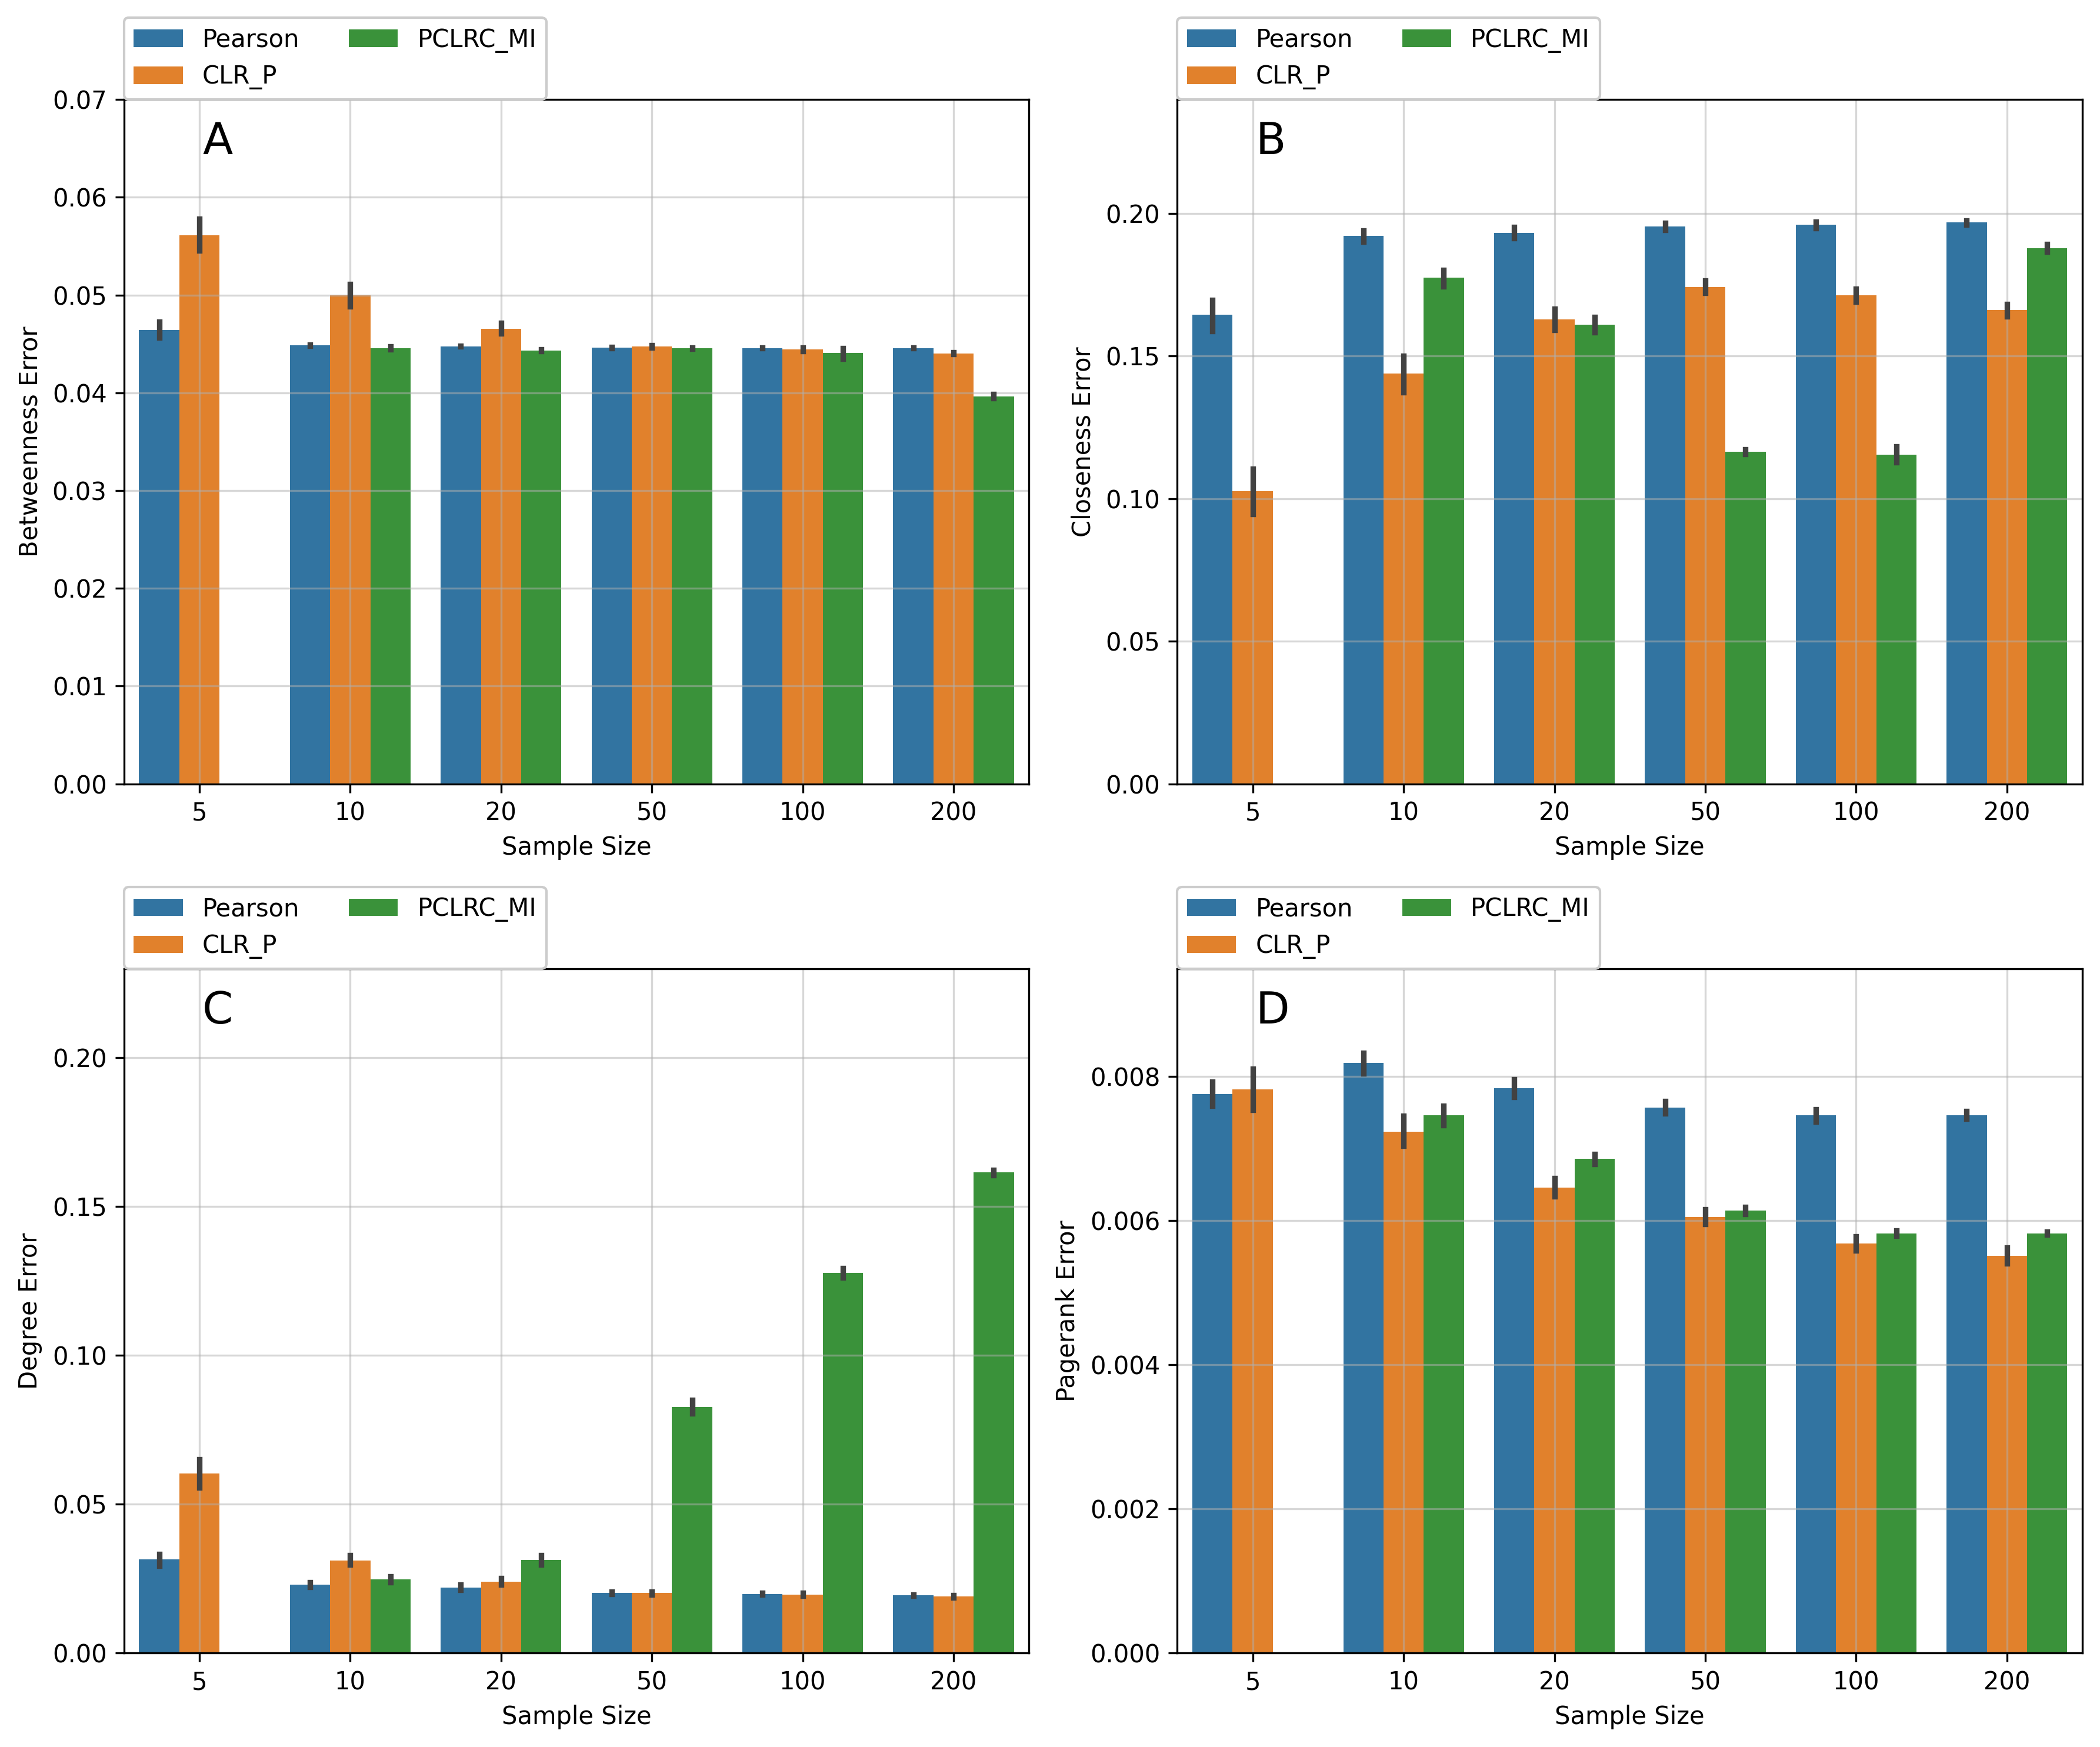

In [37]:
''' visualization '''
fig,ax = plt.subplots(2,2,figsize=(12,10),dpi=300)

for i, _m in enumerate(np.unique(test_df['metric'])):
    #ax[i//2][i%2].gca()
    sns.barplot(data = test_df[test_df['metric'] == _m],
                x='size',
                y='value',
                hue='method',ax=ax[i//2][i%2])
    ax[i//2][i%2].set_ylabel(_m.capitalize()+' Error')
    loc = (0,1)
    if _m == 'pagerank': ax[i//2][i%2].set_ylabel('PageRank Error')
    if _m == 'between': loc = 'lower right'
    if _m == 'close': loc = 'lower right'
    if _m == 'close': ax[i//2][i%2].set_ylabel('Closeness Error')
    if _m == 'pagerank': loc = 'lower right'
    if _m == 'degree': loc = (0.015,0.69)#'upper left'
    
    ax[i//2][i%2].set_xlabel('Sample Size')
    ax[i//2][i%2].grid(alpha=0.5)
    ax[i//2][i%2].legend(ncols=2, loc=loc, framealpha=1)
    ax[i//2][i%2].set_ylim(0,None)
    
plt.tight_layout()

# place panel identifiers:
panel_id = ['A','B','C','D']
ylims = [0.07, 0.24, 0.23, 0.0095]
for idx, (_id, _ylim) in enumerate(zip(panel_id, ylims)):
    ax[idx//2][idx%2].set_ylim(None,_ylim)
    ax[idx//2][idx%2].text(0.02, ax[idx//2][idx%2].get_ylim()[1]*0.92, _id, fontsize = 18)
    
# plt.savefig(f'{VIS_PATH}/centrality errors.png')


In [49]:
# these are the lower processed versions
test_df_group1 = load_eval_df(folder_path = DATA_PATH,
                              nia_methods = list(experimental_config['label_dict'].keys())[:8],
                              metric_class = 'pairwise')

100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.54it/s]


In [51]:
# these are the lower processed versions
test_df_group2 = load_eval_df(folder_path = DATA_PATH,
                              nia_methods = list(experimental_config['label_dict'].keys())[8:-5],
                              metric_class = 'pairwise')

  0%|                                                     | 0/6 [00:00<?, ?it/s]

skipping pclrc_mi 5


100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.67it/s]


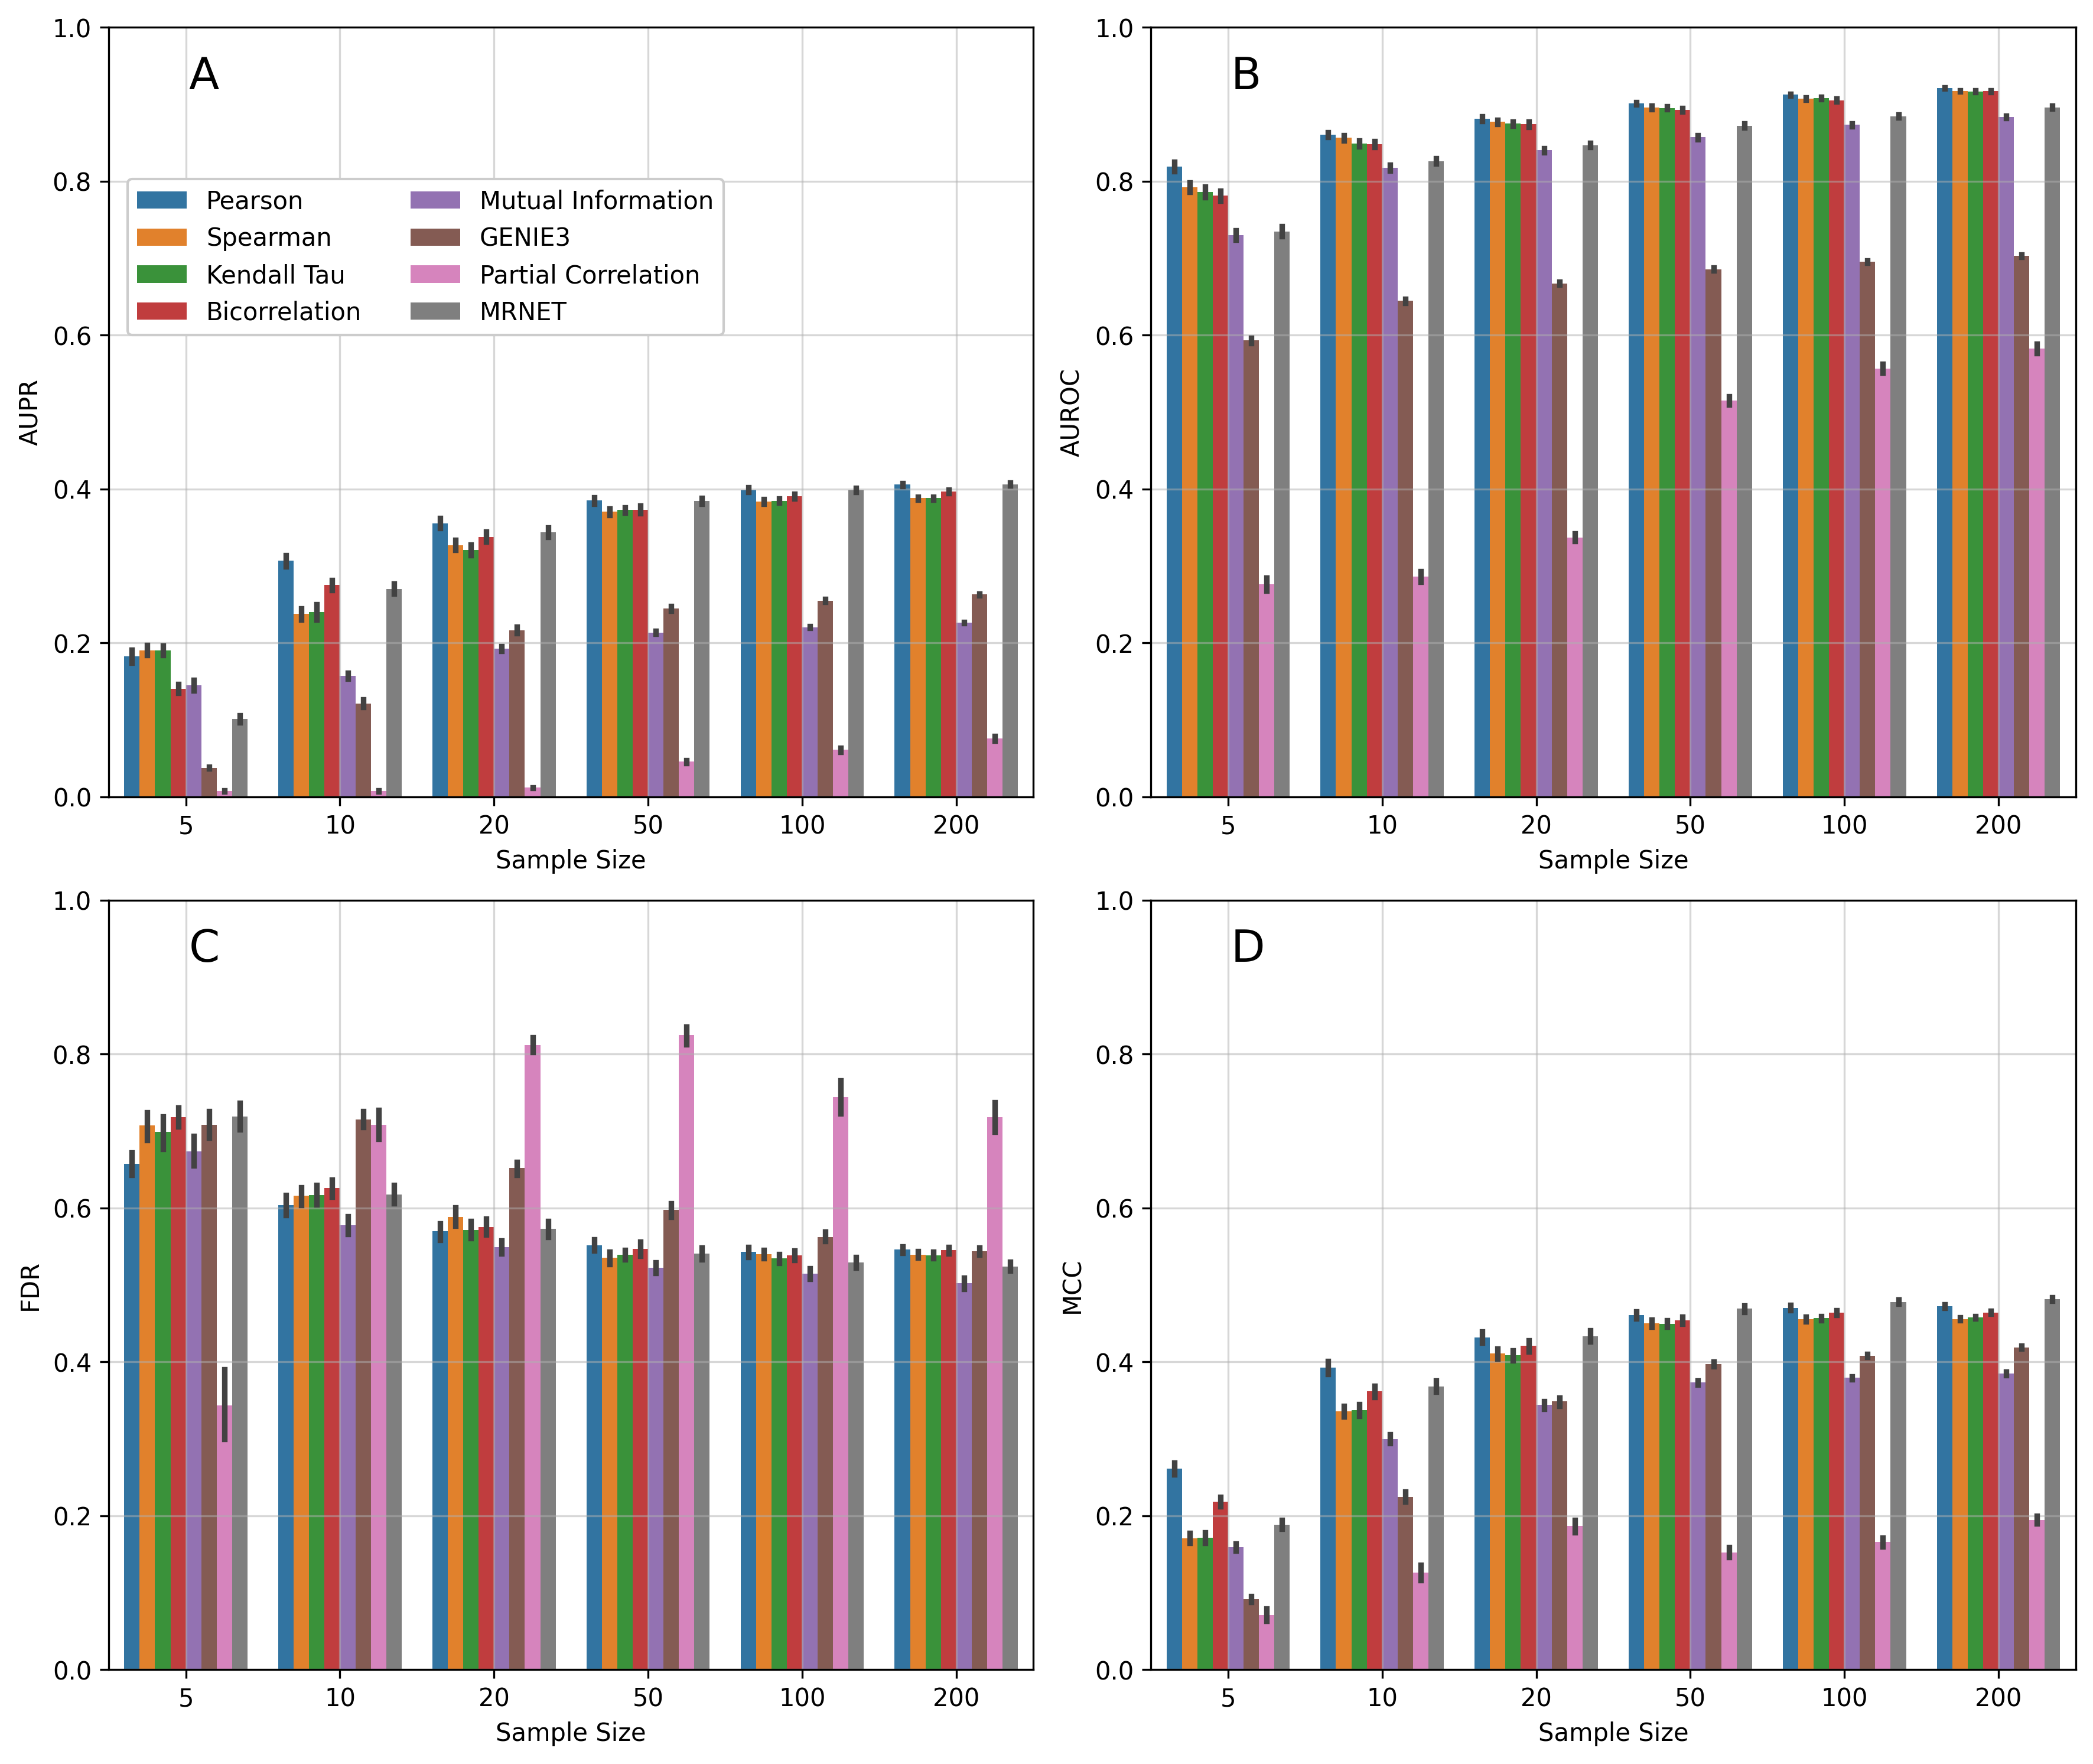

In [67]:
def evaluation_panel_vis(evaluation_dataframe) -> None:
    #
    fig,ax = plt.subplots(2,2,figsize=(12,10),dpi=300)
    
    for i, _m in enumerate(np.unique(evaluation_dataframe['metric'])):
        sns.barplot(data = evaluation_dataframe[evaluation_dataframe['metric'] == _m],
                    x='size',
                    y='value',
                    hue='method',ax=ax[i//2][i%2])
        ax[i//2][i%2].set_ylabel(_m.upper())
        ax[i//2][i%2].set_xlabel('Sample Size')
        
        if _m == 'auroc': loc = 'lower right'
        if _m == 'aupr': loc = 'upper right'
        if _m == 'fdr': loc = 'upper right'
        if _m == 'mcc': loc = 'upper right'
        ax[i//2][i%2].grid(alpha=0.5)
        ax[i//2][i%2].legend([],[],frameon=False) # remove legend
    ax[0][0].legend(ncols=2, loc=(0.02,0.6), framealpha=1)
    
    plt.tight_layout()
    
    # place panel identifiers:
    panel_id = ['A','B','C','D']
    ylims = [1, 1, 1, 1]
    for idx, (_id, _ylim) in enumerate(zip(panel_id, ylims)):
        ax[idx//2][idx%2].set_ylim(None,_ylim)
        ax[idx//2][idx%2].text(0.02, ax[idx//2][idx%2].get_ylim()[1]*0.92, _id, fontsize = 18)

evaluation_panel_vis(test_df_group1)
# plt.savefig(f'{VIS_PATH}/traditional measures group1.png')


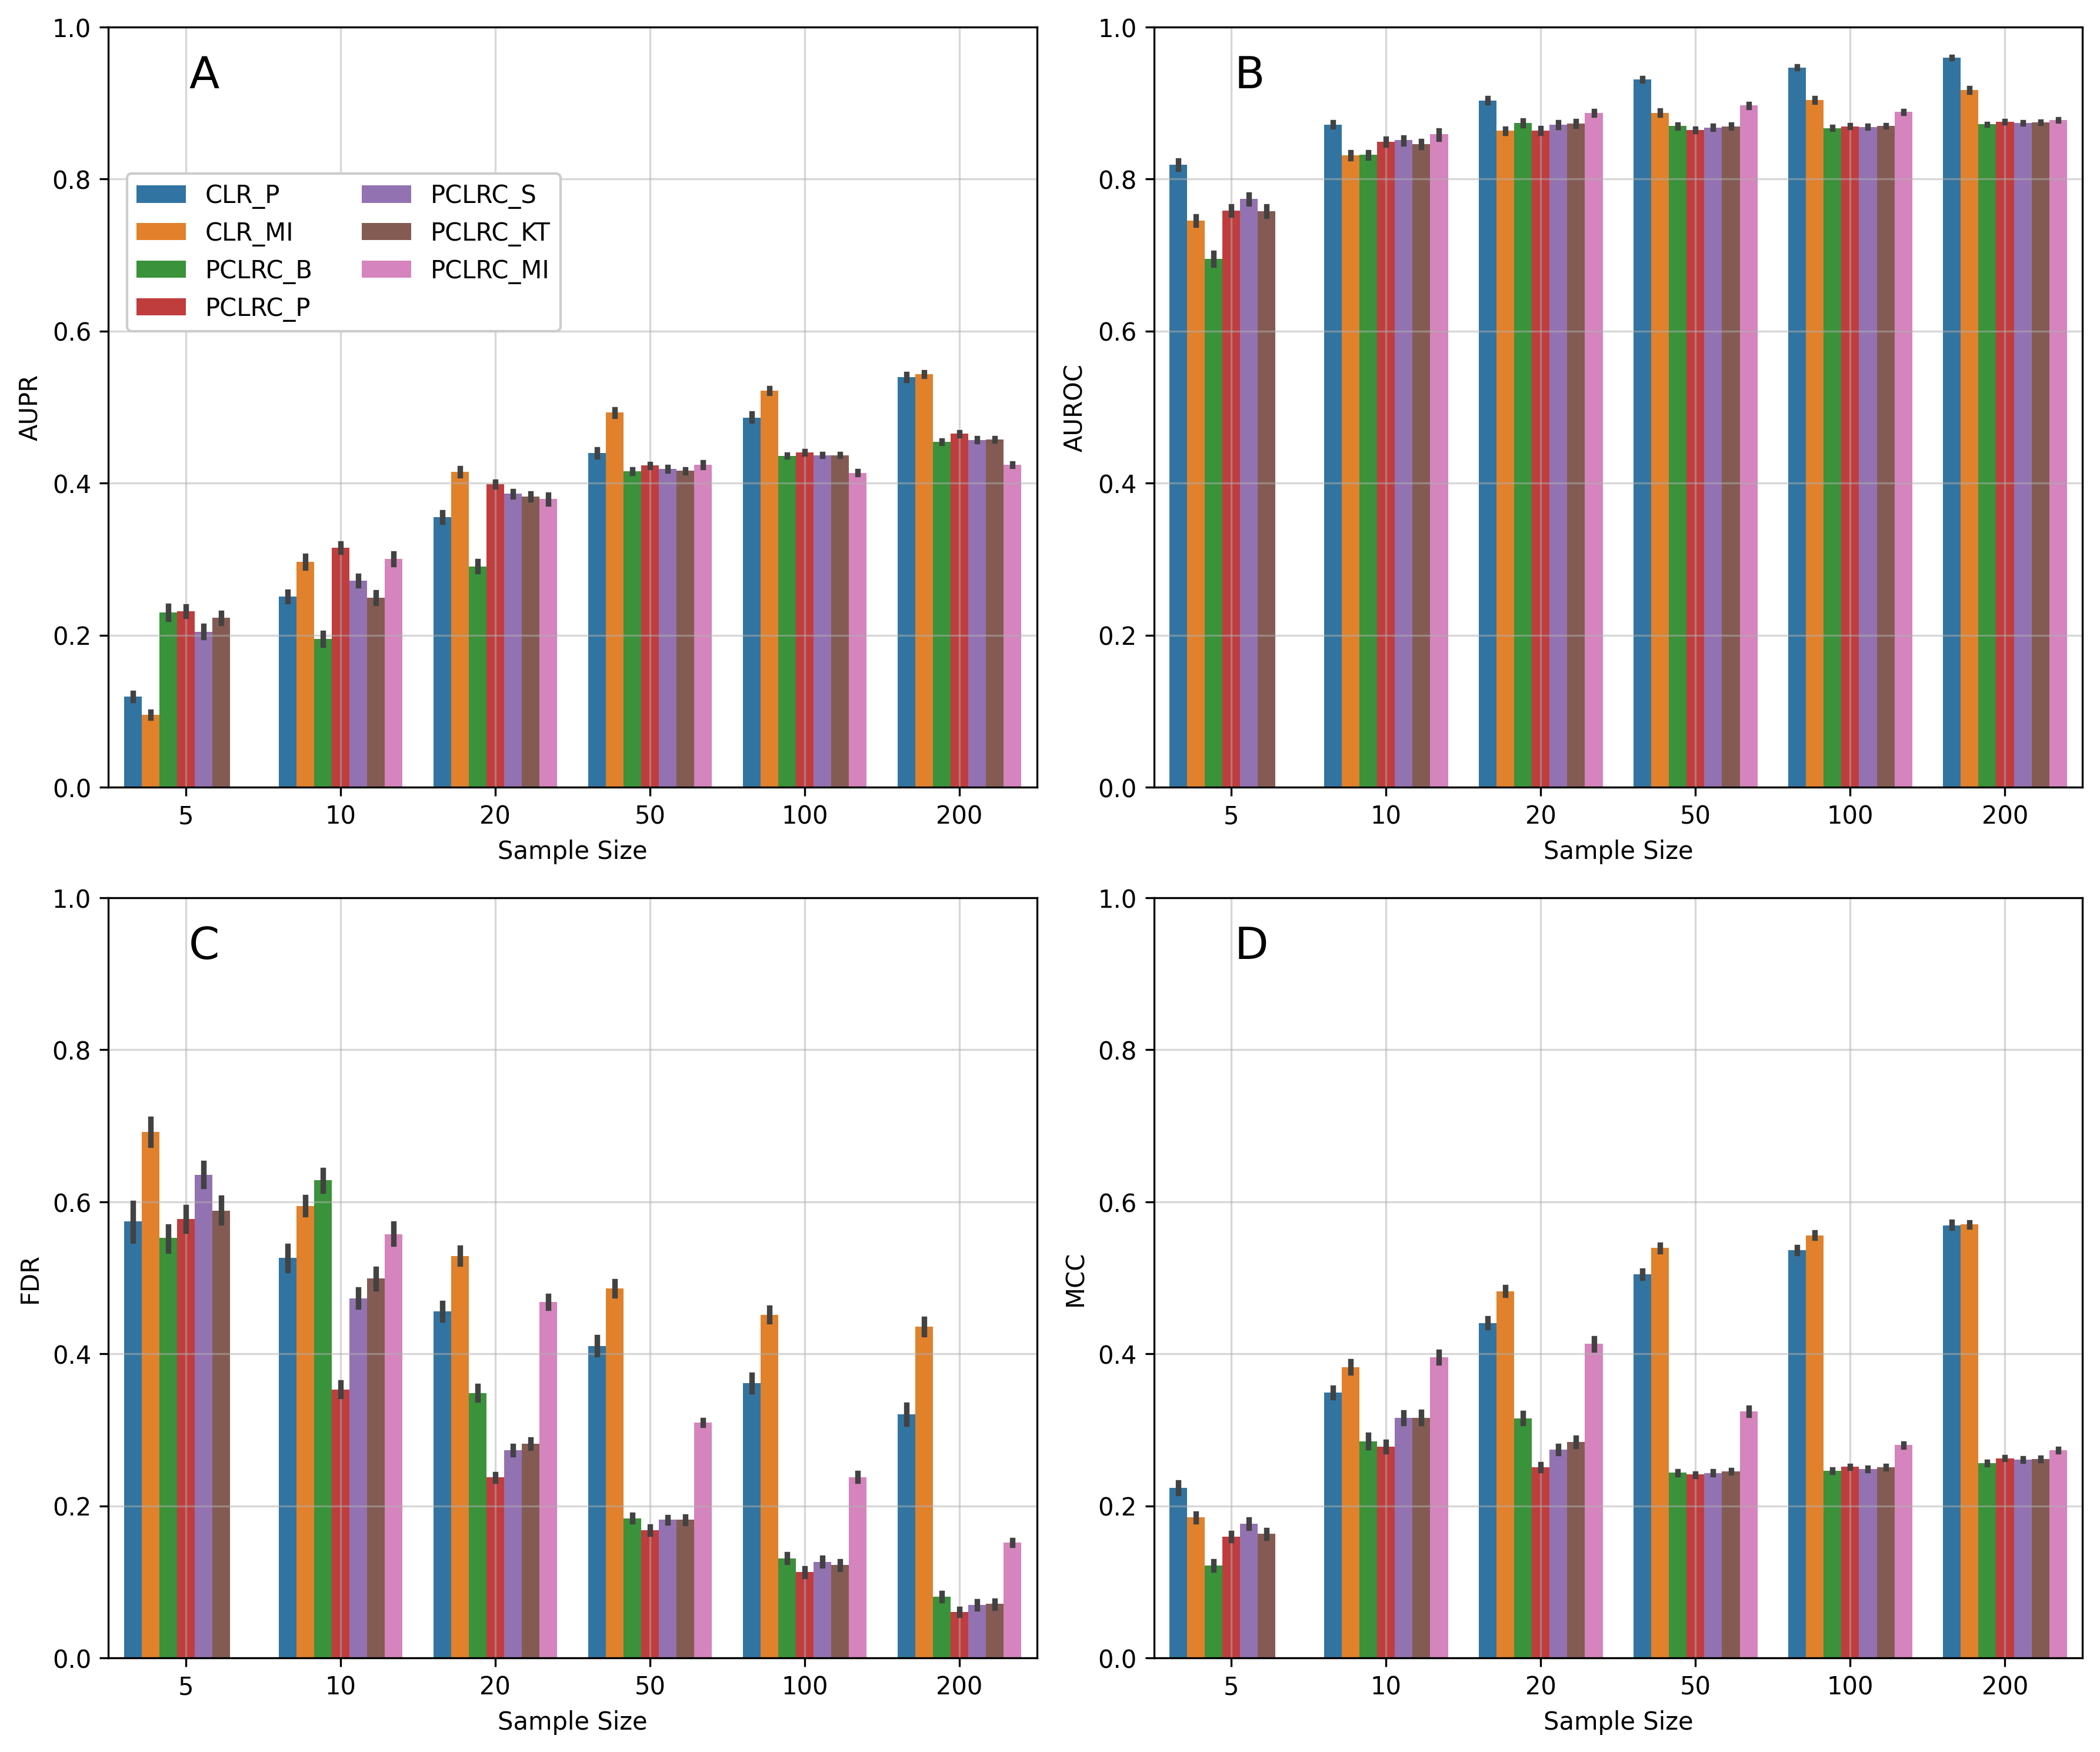

In [68]:

evaluation_panel_vis(test_df_group2)
# plt.savefig(f'{VIS_PATH}/traditional measures group2.png')


## centrality convergence

In [65]:
          
def load_convergence_df(folder_path: str, # path-like
                        nia_methods: list[str],
                        config:dict = experimental_config) -> pd.DataFrame:
    '''
    loads centrality values to show convergence
    
    nia_methods: which NIA methods to load
    label_dict: the mapping from NIA method to a presentable format
    returns a dataframe for downstream analysis
    '''
    # check that each nia method is valid (mostly a spell check)
    for _method in nia_methods:
        assert _method in config['label_dict'].keys(), 'NIA method not found (check spelling)'

    # ----- initialize df -----
    results_df = pd.DataFrame(columns=['method','size','metric']+list(experimental_config['ref_network']['metabolites']))
    _internal_row_counter = 0
    
    # loop through iteratively
    for _method in nia_methods:
        for _size in tqdm(config['sample_sizes']):

            # ------------ load NIA data ------------
            path = f'{folder_path}/{_method}/{_method}_{_size}.npy'
            if not Path(path).exists():
                print(f'skipping {_method} {_size}') # specifically for pclrc_mi_5
                continue
            test_data = np.load(path)
            test_data = copy_to_upper(test_data)

            # --- remove NaN inferences (should occur basically never, but will break downstream things if it does occur)
            nan_mask = np.isfinite(test_data.reshape(config['n_reps'],-1).max(axis=1))
            test_data = test_data[nan_mask]
            
            # ------ do the evaluations --------
            for i, _data in enumerate(test_data):

                temp_eval_dict = calc_centrality_evals(assoc_matrix = _data,
                                                       config = config)
                
                # log the evaluations in the dataframe
                for (_key, _v) in temp_eval_dict.items():
                    results_df.loc[_internal_row_counter] = [config['label_dict'][_method], _size, _key, *_v]
                    _internal_row_counter += 1

    return results_df


In [129]:
test_convergence_group1 = load_convergence_df(folder_path = DATA_PATH,
                                              nia_methods = list(experimental_config['label_dict'].keys())[:8])


100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.27s/it]


In [130]:

def add_MAE_centrality(df: pd.DataFrame, config = experimental_config) -> pd.DataFrame:
    # this adds a column to summarize the centrality errors

    # ensure the dataframe has the correct metrics
    dataframe_metrics_set = set(np.unique(df['metric']).astype(str))
    ref_centrality_set = set(list(config['ref_centralities'].keys()))
    assert dataframe_metrics_set == ref_centrality_set, "dataframe centralities don't match expected"

    # initialize new column
    new_mae_column = np.zeros(len(df))
    metabolites = np.array(config['ref_network']['metabolites']) # pull column names
    # loop over centralities
    for _centrality in dataframe_metrics_set:
        ref_cent = config['ref_centralities'][_centrality] # get reference centralities
        mask = (df['metric'] == _centrality)        
        # select entries for centrality method
        df_cent = df[mask]
        # isolate metabolite centrality values
        metabolite_cents = np.array(df_cent[metabolites])
        # MAE
        temp_mae = abs(metabolite_cents - ref_cent).mean(axis=1)
        # update column
        new_mae_column[mask] = temp_mae 
    
    # append column, return the dataframe
    df['MAE'] = new_mae_column
    return df

test_convergence_group1 = add_MAE_centrality(test_convergence_group1)

Degree
Betweenness
Closeness
PageRank


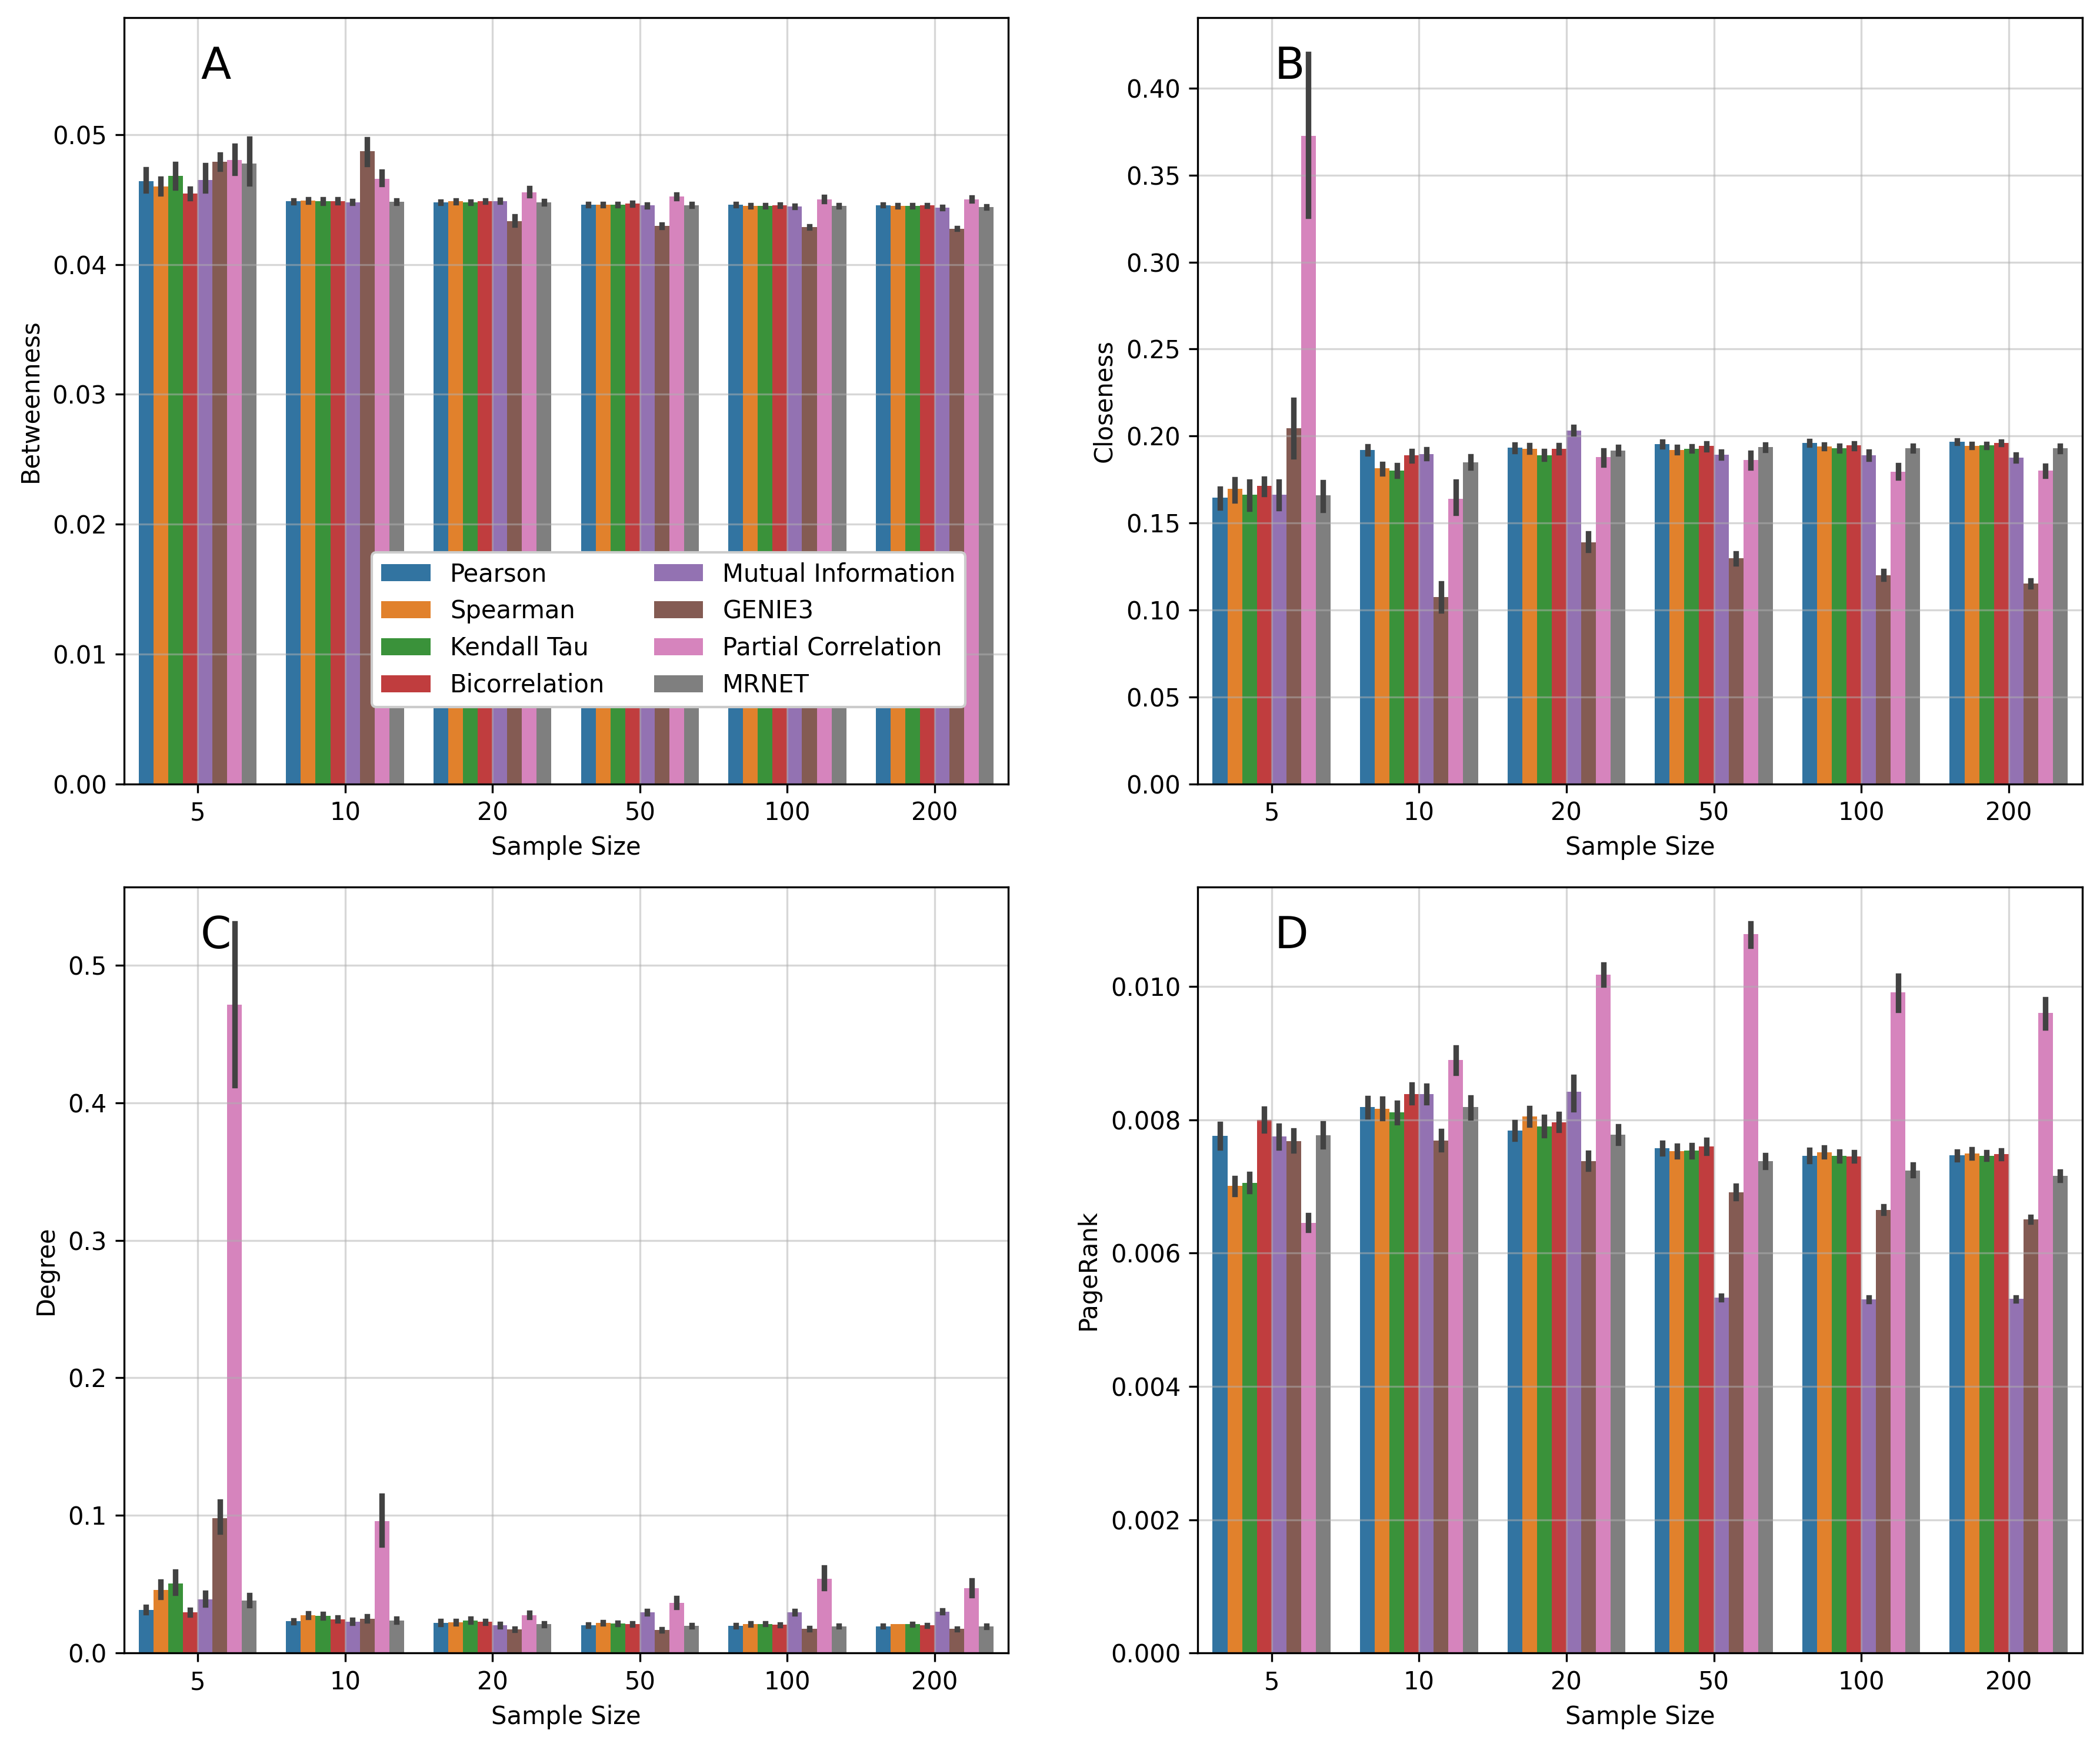

In [160]:
def evaluation_panel_vis_g1(evaluation_dataframe) -> None:
    #
    fig,ax = plt.subplots(2,2,figsize=(12,10),dpi=300)
    
    for i, _m in enumerate(np.unique(evaluation_dataframe['metric'])):
        sns.barplot(data = evaluation_dataframe[evaluation_dataframe['metric'] == _m],
                    x='size',
                    y='MAE',
                    hue='method',ax=ax[i//2][i%2])
        ax[i//2][i%2].set_ylabel(_m)
        ax[i//2][i%2].set_xlabel('Sample Size')

        ax[i//2][i%2].grid(alpha=0.5)
        ax[i//2][i%2].legend([],[],frameon=False) # remove legend
    ax[0][0].legend(ncols=2, loc=(0.28,0.1), framealpha=1)
    
    plt.tight_layout()
    
    # place panel identifiers:
    panel_id = ['A','B','C','D']
    ylims = [0.059, None, None, None]
    for idx, (_id, _ylim) in enumerate(zip(panel_id, ylims)):
        ax[idx//2][idx%2].set_ylim(None,_ylim)
        ax[idx//2][idx%2].text(0.02, ax[idx//2][idx%2].get_ylim()[1]*0.92, _id, fontsize = 18)
        
evaluation_panel_vis_g1(test_convergence_group1)
# plt.savefig(f'{VIS_PATH}/centrality_residual_g1.png')


In [145]:
# repeat for the clr and pclrcs
test_convergence_group2 = load_convergence_df(folder_path = DATA_PATH,
                                              nia_methods = list(experimental_config['label_dict'].keys())[8:-5])

test_convergence_group2 = add_MAE_centrality(test_convergence_group2)


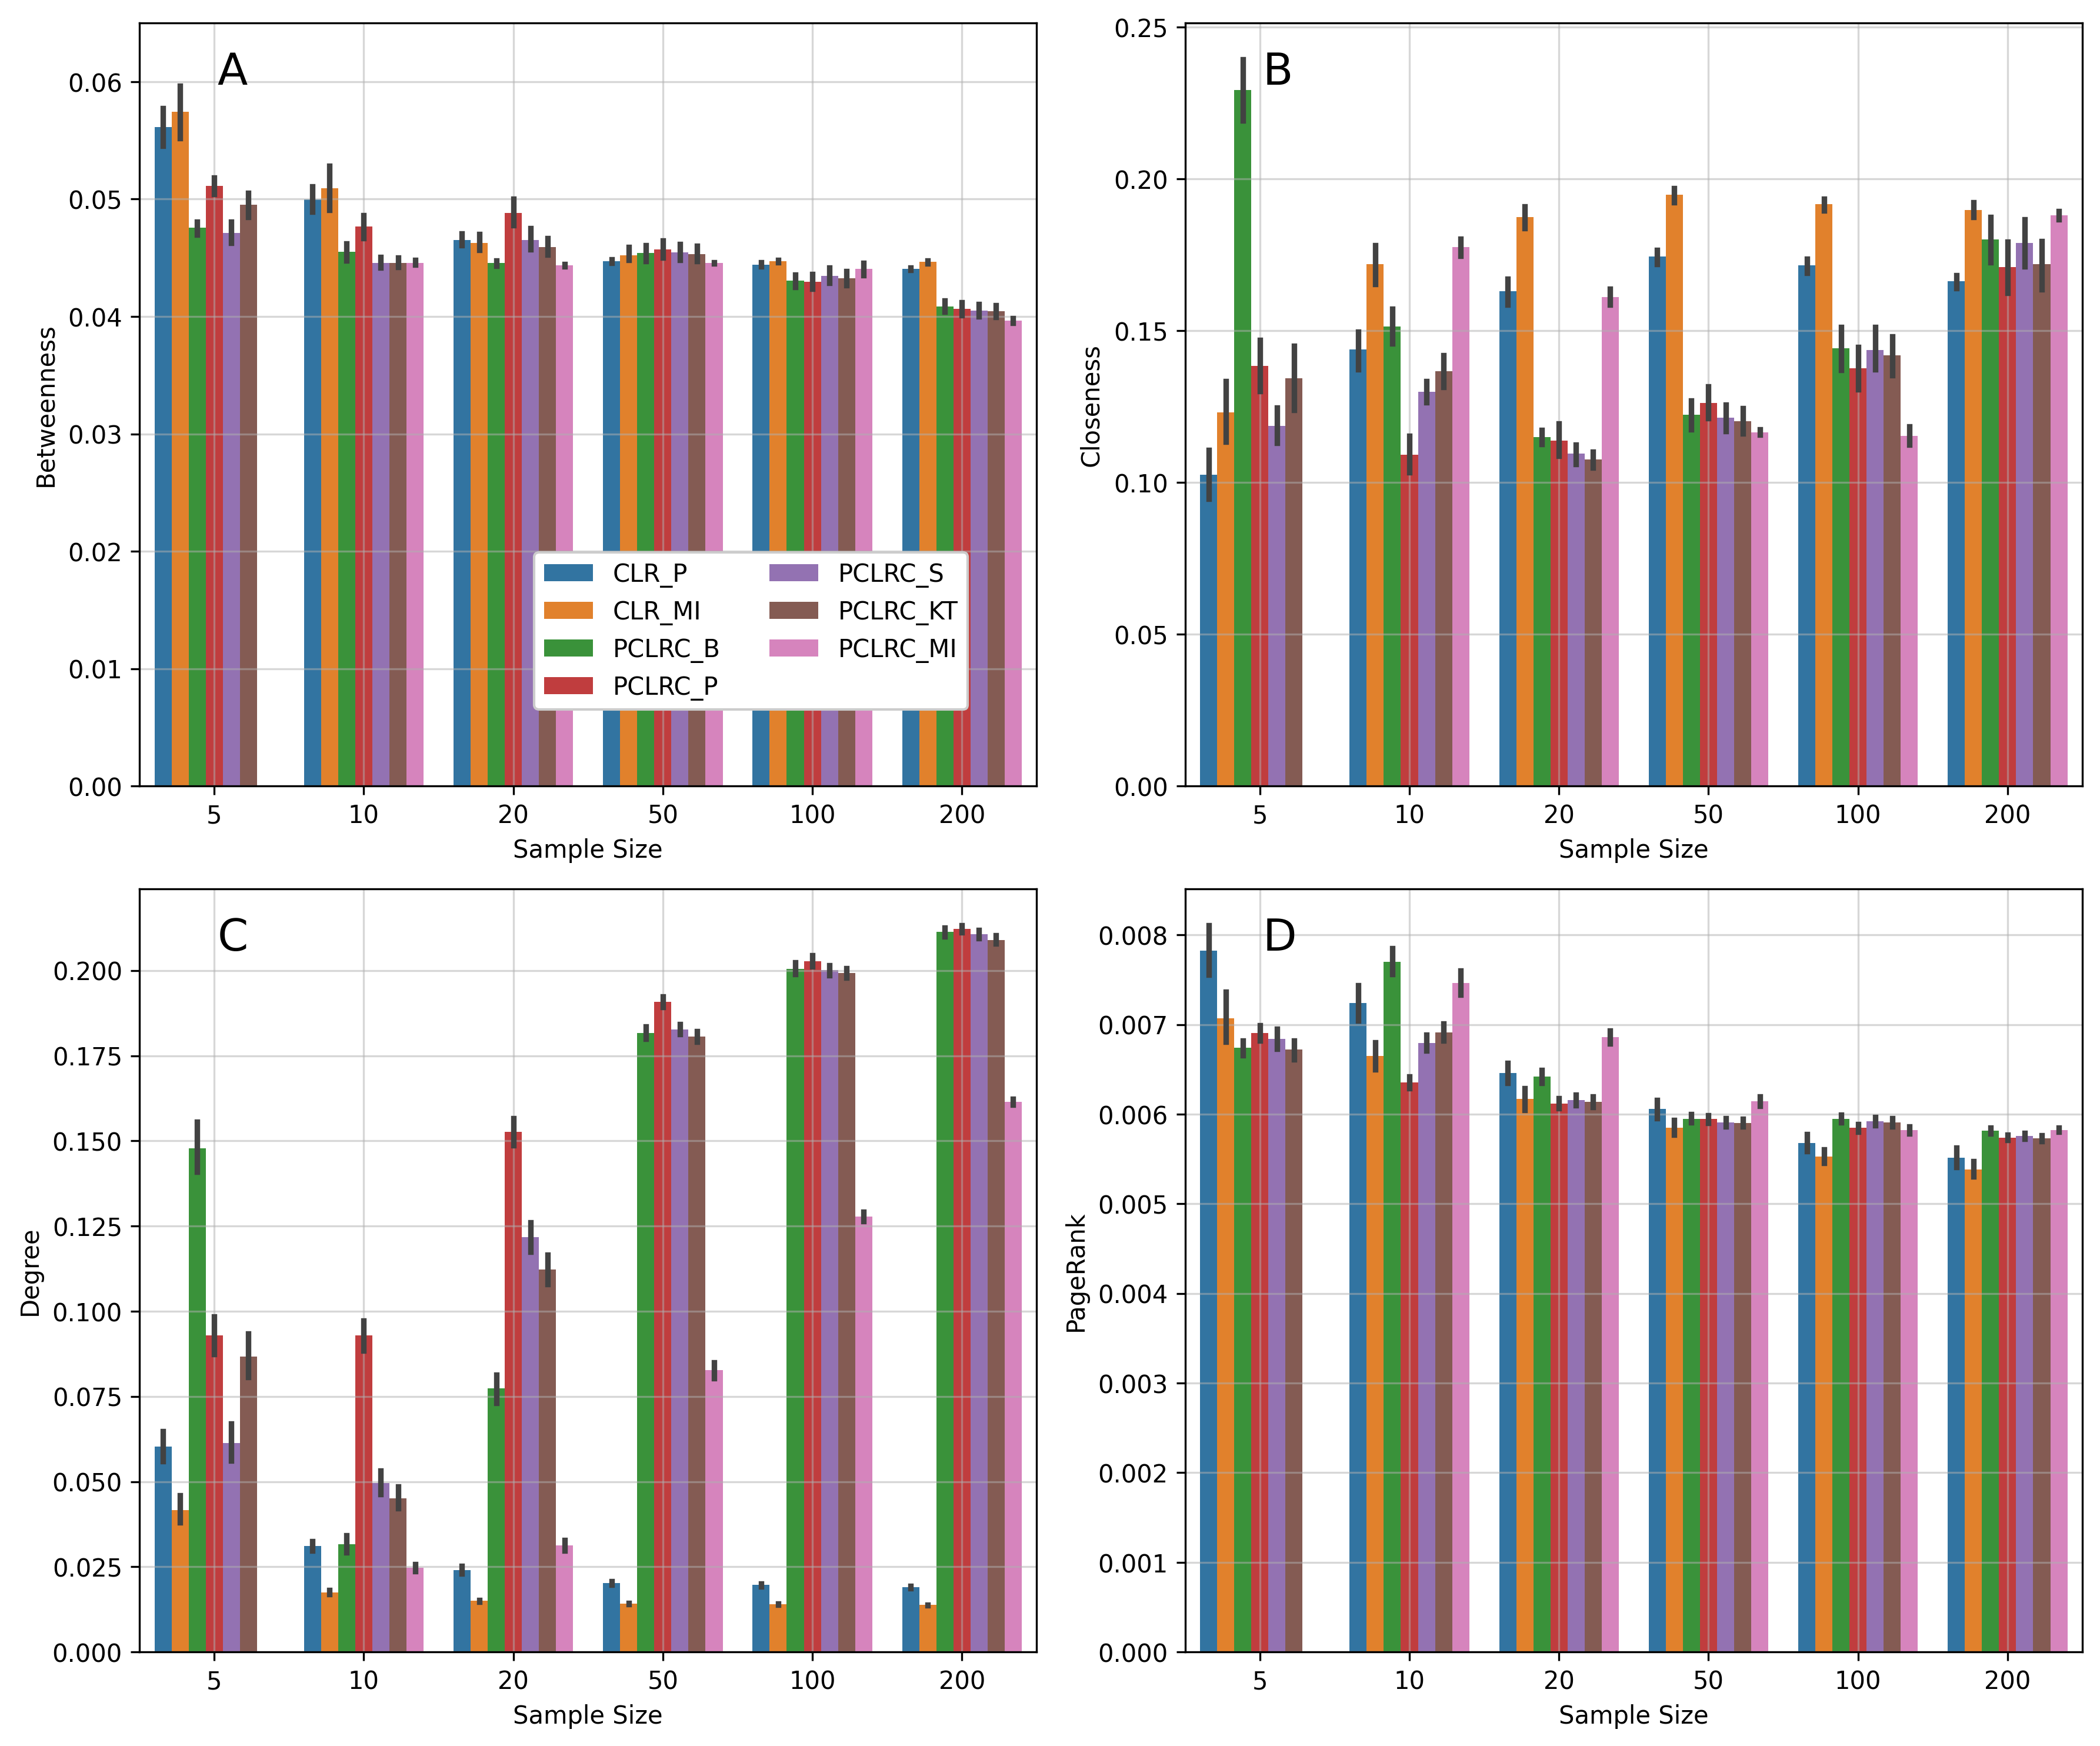

In [159]:
def evaluation_panel_vis_g2(evaluation_dataframe) -> None:
    # some modified parameters for this different group (legend positioning, ylim)
    fig,ax = plt.subplots(2,2,figsize=(12,10),dpi=300)
    
    for i, _m in enumerate(np.unique(evaluation_dataframe['metric'])):
        sns.barplot(data = evaluation_dataframe[evaluation_dataframe['metric'] == _m],
                    x='size',
                    y='MAE',
                    hue='method',ax=ax[i//2][i%2])
        ax[i//2][i%2].set_ylabel(_m)
        ax[i//2][i%2].set_xlabel('Sample Size')

        ax[i//2][i%2].grid(alpha=0.5)
        ax[i//2][i%2].legend([],[],frameon=False) # remove legend
    ax[0][0].legend(ncols=2, loc=(0.44,0.1), framealpha=1)
    
    plt.tight_layout()
    
    # place panel identifiers:
    panel_id = ['A','B','C','D']
    ylims = [0.065, None, None, None]
    for idx, (_id, _ylim) in enumerate(zip(panel_id, ylims)):
        ax[idx//2][idx%2].set_ylim(None,_ylim)
        ax[idx//2][idx%2].text(0.02, ax[idx//2][idx%2].get_ylim()[1]*0.92, _id, fontsize = 18)

evaluation_panel_vis_g2(test_convergence_group2)
# plt.savefig(f'{VIS_PATH}/centrality_residual_g2.png')


In [ ]:
# how specific metabolites converge to a centrality measure

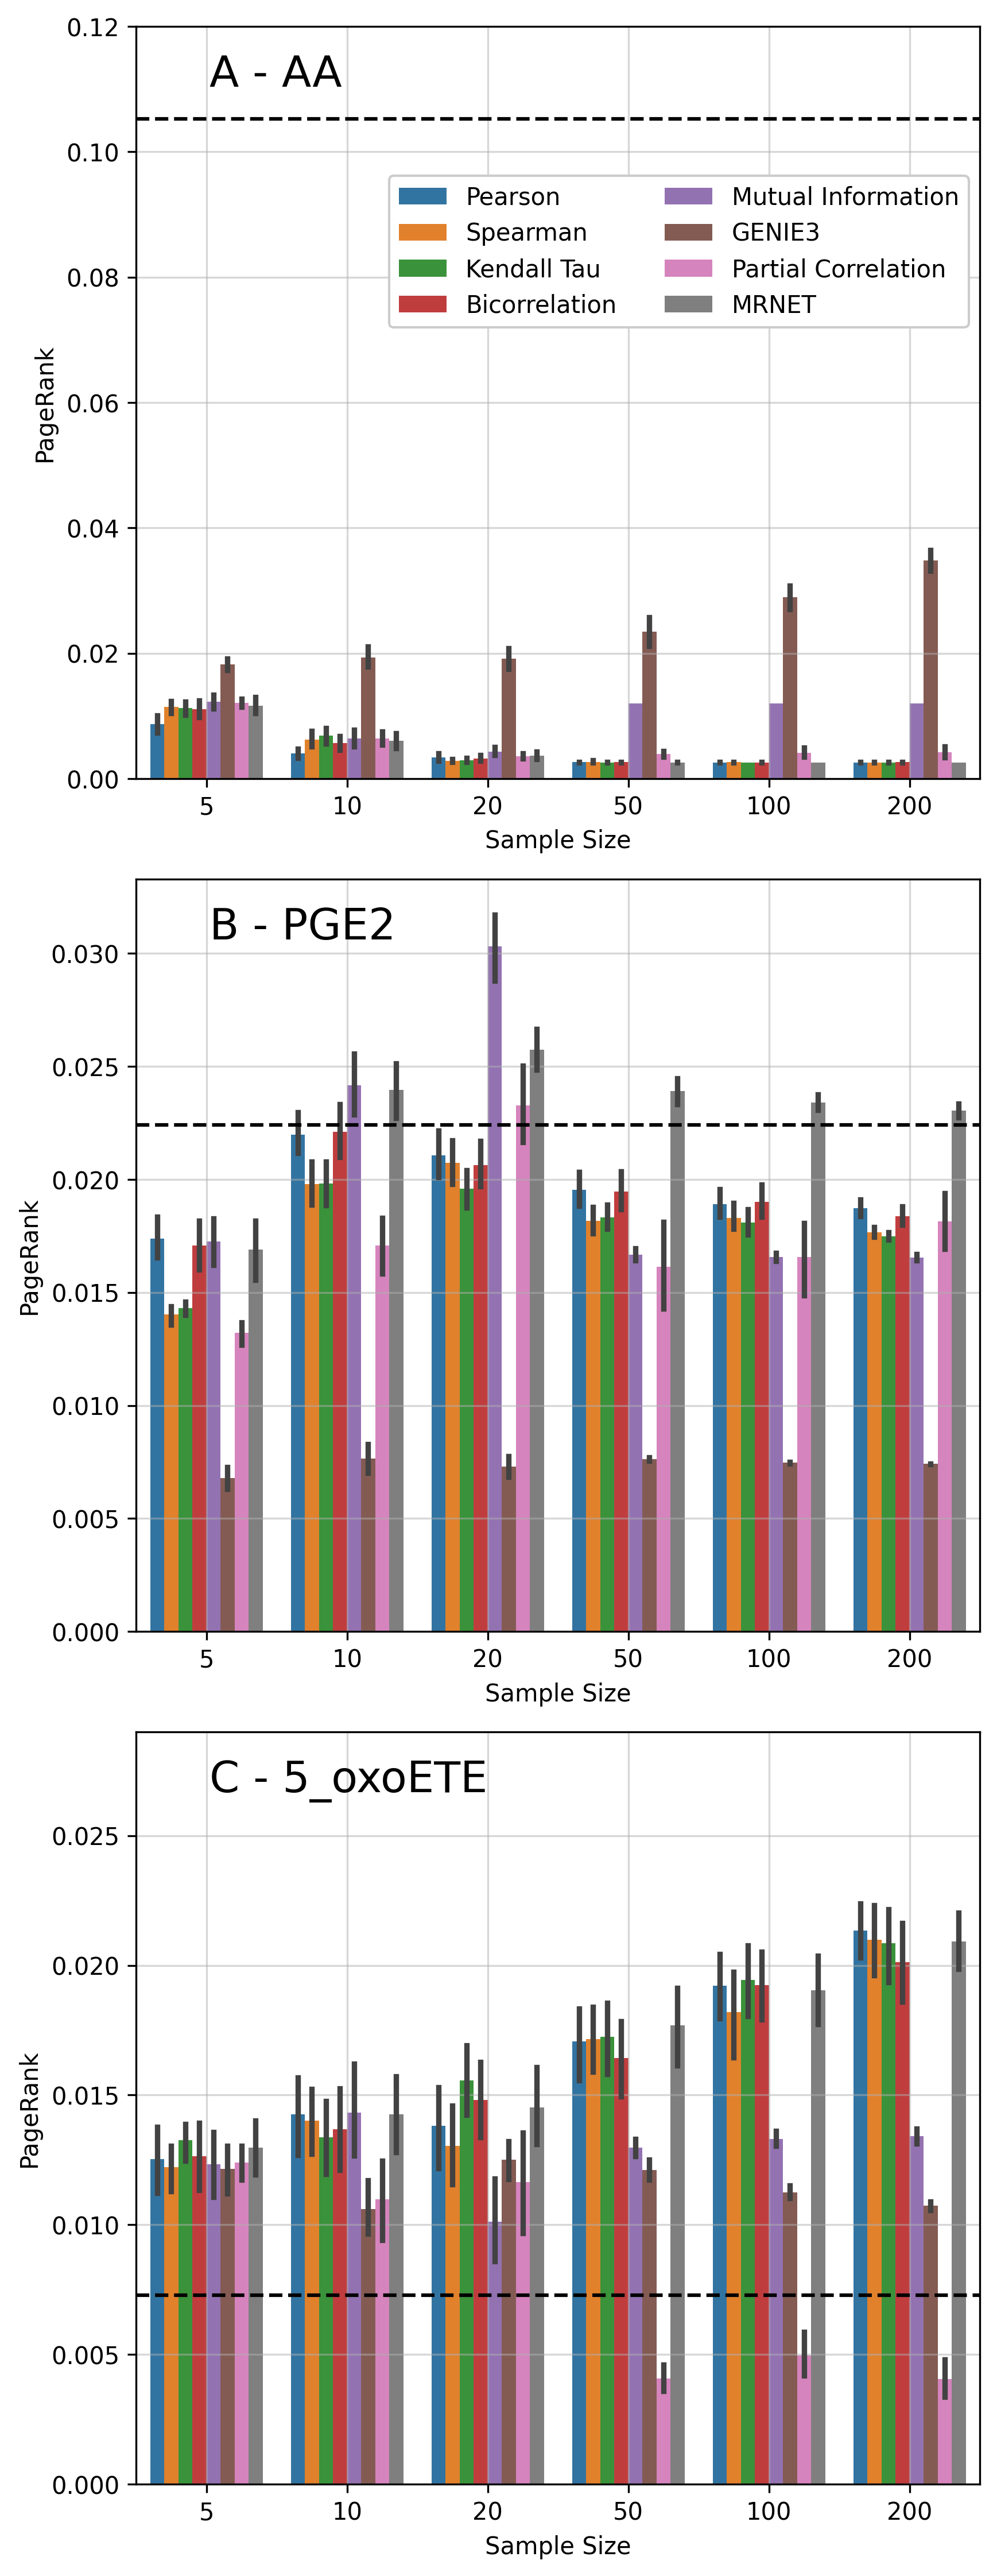

In [169]:
def vis_metabolite_convergence(df:pd.DataFrame, metabolites: list[str],
                               centrality_metric = 'PageRank',
                               config = experimental_config) -> None:
    
    fig,ax = plt.subplots(len(metabolites),1,figsize=(6,15),dpi=300)
    
    for i, _node_idx in enumerate(metabolites):
        sns.barplot(data = df[df['metric'] == centrality_metric],
                    x='size',
                    y=f'{_node_idx}',
                    hue='method',
                    ax=ax[i])
    
        target_index = np.where(config['ref_network']['metabolites'] == _node_idx)[0]
        ax[i].axhline(config['ref_centralities']['PageRank'][target_index],ls='--',c='k')
        
        ax[i].set_ylabel('PageRank')
        ax[i].set_xlabel('Sample Size')
        ax[i].grid(alpha=0.5)
        #if i == 0: loc = 'upper right' #(0.49, 0.65) # AA
        #if i == 1: loc = 'upper right' # PGE2
        #if i == 2: loc = (0.015, 0.63) # oxo
        ax[i].legend([],[],frameon=False) # remove legend
    ax[0].legend(ncols=2, loc=(0.3,0.6), framealpha=1)
        
    plt.tight_layout()
    
    # place panel identifiers:
    panel_id = ['A','B','C']
    ylims = [0.12, None, 0.029]
    for idx, (_id, _ylim, _metabolite) in enumerate(zip(panel_id, ylims, metabolites)):
        ax[idx].set_ylim(None,_ylim)
        ax[idx].text(0.02, ax[idx].get_ylim()[1]*0.92, f'{_id} - {_metabolite}', fontsize = 18)
    
node_idxs = ['AA','PGE2','5_oxoETE']
vis_metabolite_convergence(df = test_convergence_group1, metabolites = node_idxs)
# plt.savefig(f'{VIS_PATH}/node_centrality_convergence.png')
        

## graphical centrality errors
place metabolite centrality errors on the nodes in their position on the inferred graph

In [171]:
# load association matrix for graph visualization

_size = 200
_sample_idx = 10
temp_data = np.load(f'{DATA_PATH}/clrp_{_size}.npy')[_sample_idx]
print(temp_data.shape)

(83, 83)


In [172]:
# instantiate the inferred graph

def recovered_graph_preloaded(assoc_matrix:np.array,
                              config:dict = experimental_config) -> nx.Graph:
    '''
    convert an association matrix to a graph
    '''
    assert len(assoc_matrix.shape) == 2, 'expects a 2D association matrix'
    # get binarized assoc matrix
    bin_representation = _best_binarization(assoc_matrix = assoc_matrix,
                                            ref_adj_matrix = config['ref_network']['adj'])
    # create graph with binarized array
    my_graph = nx.from_numpy_array(bin_representation)
    # label nodes with metabolite name
    my_graph = nx.relabel_nodes(my_graph,
                                dict(zip(np.arange(len(config['ref_network']['metabolites'])),
                                         config['ref_network']['metabolites'])))
    
    return my_graph


In [173]:
# functions to map positions and values to metabolites that simplify visualization and graph manipulation
def zip_to_metabolites(values, # Iterable
                       config: dict = experimental_config) -> dict:
    '''
    creates a dictionary where keys are the metabolite mapping to the input values
    '''
    metabolites = config['ref_network']['metabolites']
    return dict(zip(metabolites, values))
    
def process_positions(config: dict = experimental_config) -> dict[str,np.array]:
    '''
    using the reference network from the config file,
    create a dictionary for positioning metabolites in graph visualization
    '''
    positions = config['ref_network']['pos']
    return zip_to_metabolites(config['ref_network']['pos'], config=config)
    
def place_labels(positions_dict: dict[str,np.array],
                 values: list,
                 threshold: float) -> None:
    ''' places labels at positions, colouring by value (making it more readable) '''
    for (_label, _pos), _val in zip(positions_dict.items(), values):
        if abs(_val) > threshold: _c = 'w'
        else: _c = 'k'
        plt.text(*_pos, _label, c=_c, ha='center', va='center')


In [174]:
# the visualization function

def make_centrality_res_plot(graph: nx.Graph,
                             positions_dict: dict[str,np.array],
                             cbar_label: str,
                             metabolite_values: dict[str,np.array],
                             figsize: tuple[float,float] = (26,16)) -> None:
    
    plt.figure(figsize=figsize)
    ax = plt.gca()
    
    # -- plot edges --
    nx.draw_networkx_edges(graph, pos = positions_dict, alpha = 0.2)

    # -- plot nodes --
    cmap = 'RdBu'
    color_values = np.array(list(metabolite_values.values()))
    #print(color_values)
    positions_locations = np.array(list(positions_dict.values()))
    panel = ax.scatter(*positions_locations.T,
                       s=800,
                       c=color_values, cmap=cmap,
                       vmin=-max(abs(color_values)), vmax=max(abs(color_values)),
                       edgecolor='lightgray')
    
    # -- add node labels --
    place_labels(positions_dict = positions_dict,
                 values = color_values,
                 threshold = 0.55 * max(color_values))
    
    # -- do some figure cleanup --
    plt.axis('off')
    cax = ax.inset_axes([0.1, 0.1, 0.3, 0.04])
    plt.colorbar(panel, cax=cax, orientation='horizontal').set_label(label=cbar_label,size=25,weight='normal')


In [177]:
# calculate raw centrality scores for each metabolite
temp_eval_dict = calc_centrality_evals(assoc_matrix = temp_data,
                                       config = experimental_config)

# calculate error from reference network
method = 'PageRank'
color_values = temp_eval_dict[method] - experimental_config['ref_centralities'][method]

# stick that into a dictionary for mapping to nodes
values_dict = dict(zip(experimental_config['ref_network']['metabolites'],
                       experimental_config['ref_centralities'][method] - temp_eval_dict[method]))

# create inferred graph
my_graph = recovered_graph_preloaded(temp_data)

<Figure size 1920x1440 with 0 Axes>

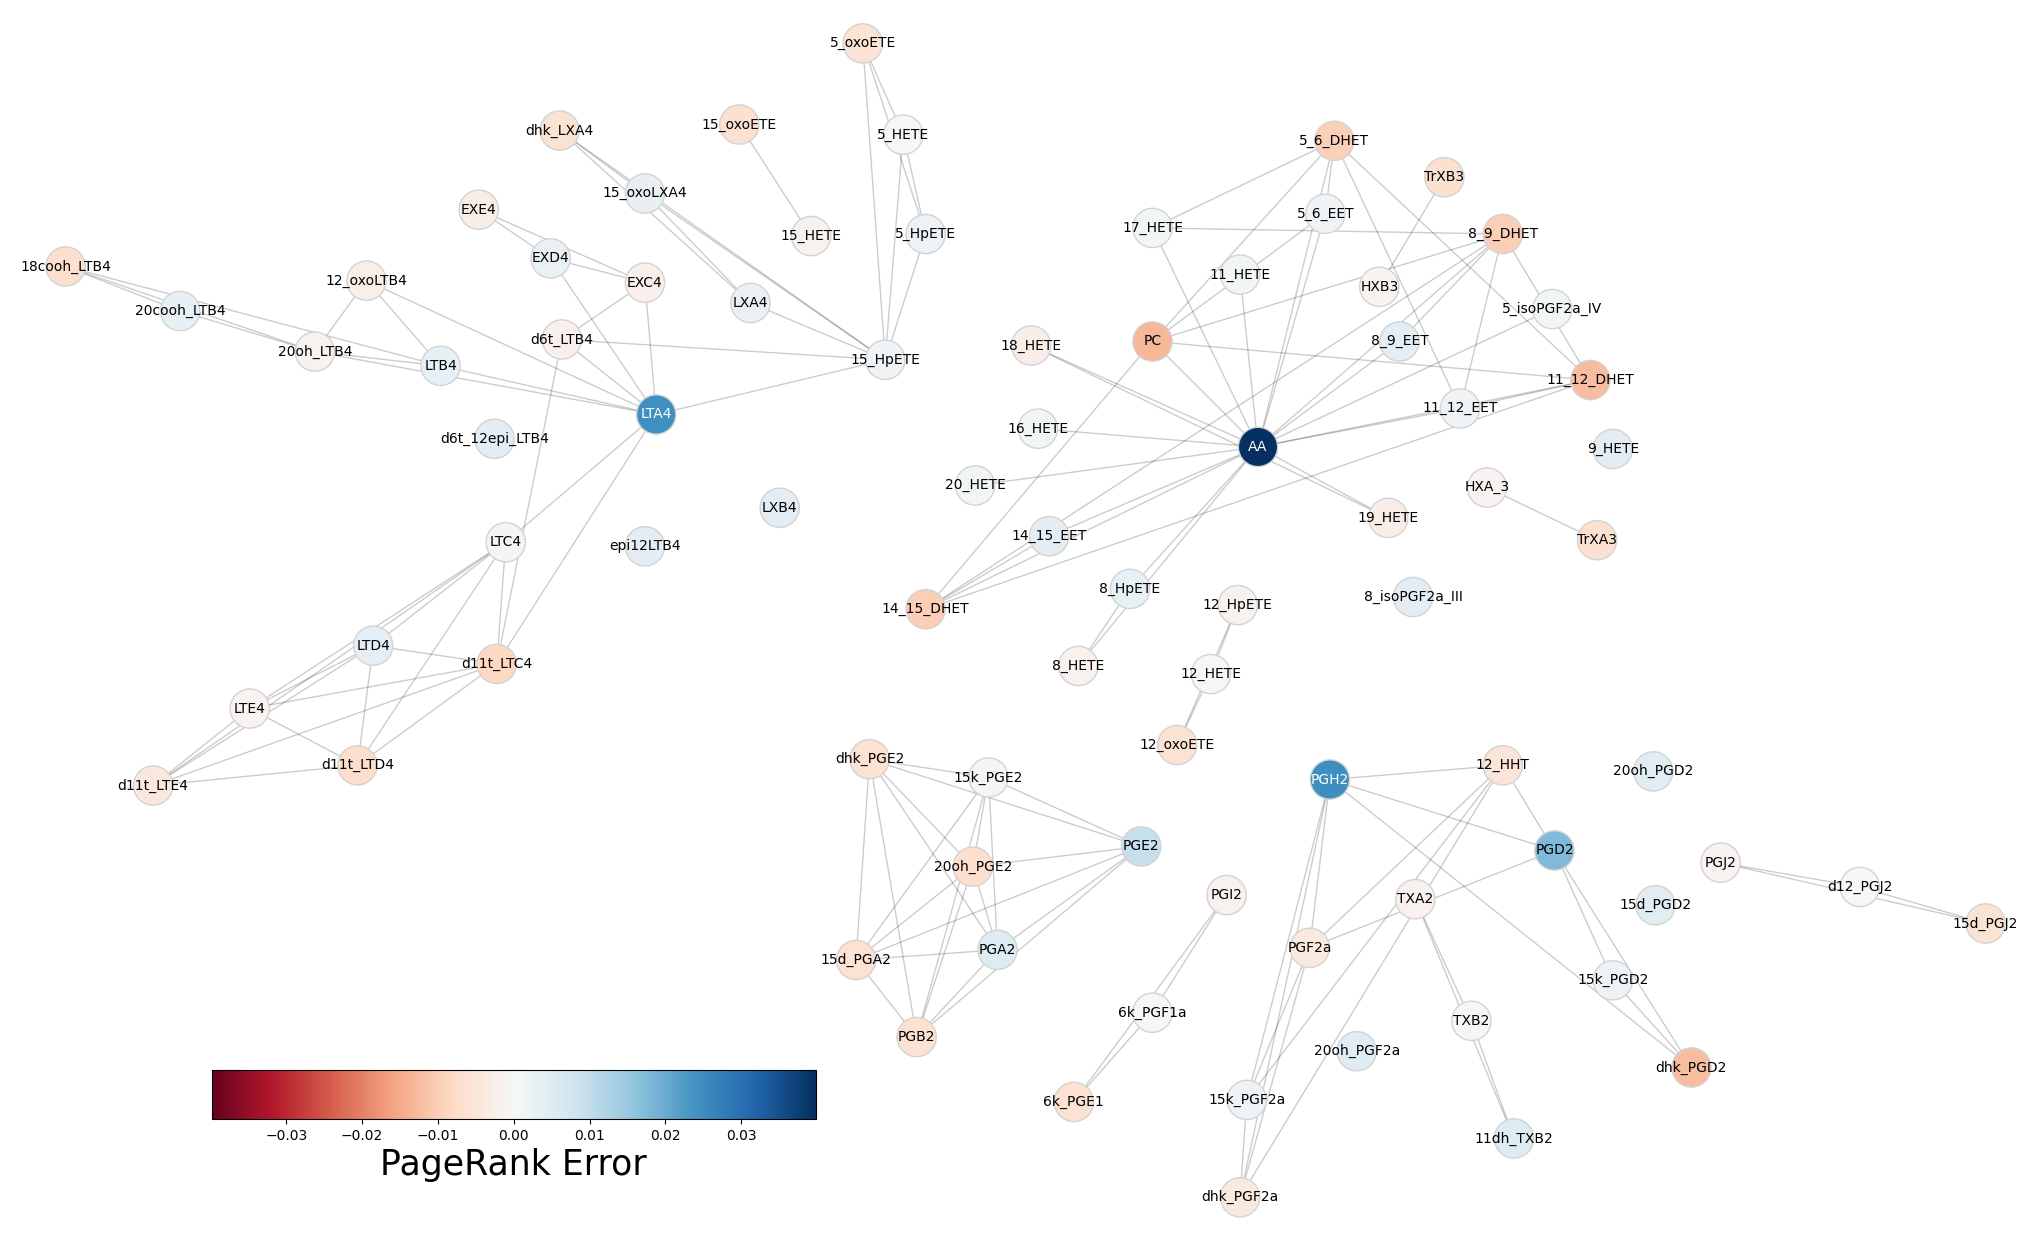

In [181]:
plt.figure(dpi=300)
make_centrality_res_plot(my_graph,
                         positions_dict = process_positions(),
                         cbar_label = 'PageRank Error',
                         metabolite_values = values_dict)
plt.gca().set_xlim(30,1950)
plt.gca().set_ylim(-1300,0);

## single shot network differentiation
visualization of inferred networks from "young" or "old"

In [182]:

# make graphs
preloaded_healthy = np.load(f'{DIFFERENTIATION_DATA_PATH}copasi_healthy_clrp200.npy')
preloaded_disease = np.load(f'{DIFFERENTIATION_DATA_PATH}copasi_disease_clrp200.npy')
healthy_graph = recovered_graph_preloaded(preloaded_healthy[0])
disease_graph = recovered_graph_preloaded(preloaded_disease[0])


In [183]:

# identify the metabolites directly connected to the mutation (to be coloured differently)
direct_metabolites = np.zeros(len(healthy_graph))

for i, _node in enumerate(healthy_graph):
    if _node in ['PGE2','15k_PGD2','PGD2','15k_PGE2']:
        direct_metabolites[i] = 80
    else:
        direct_metabolites[i] = 0


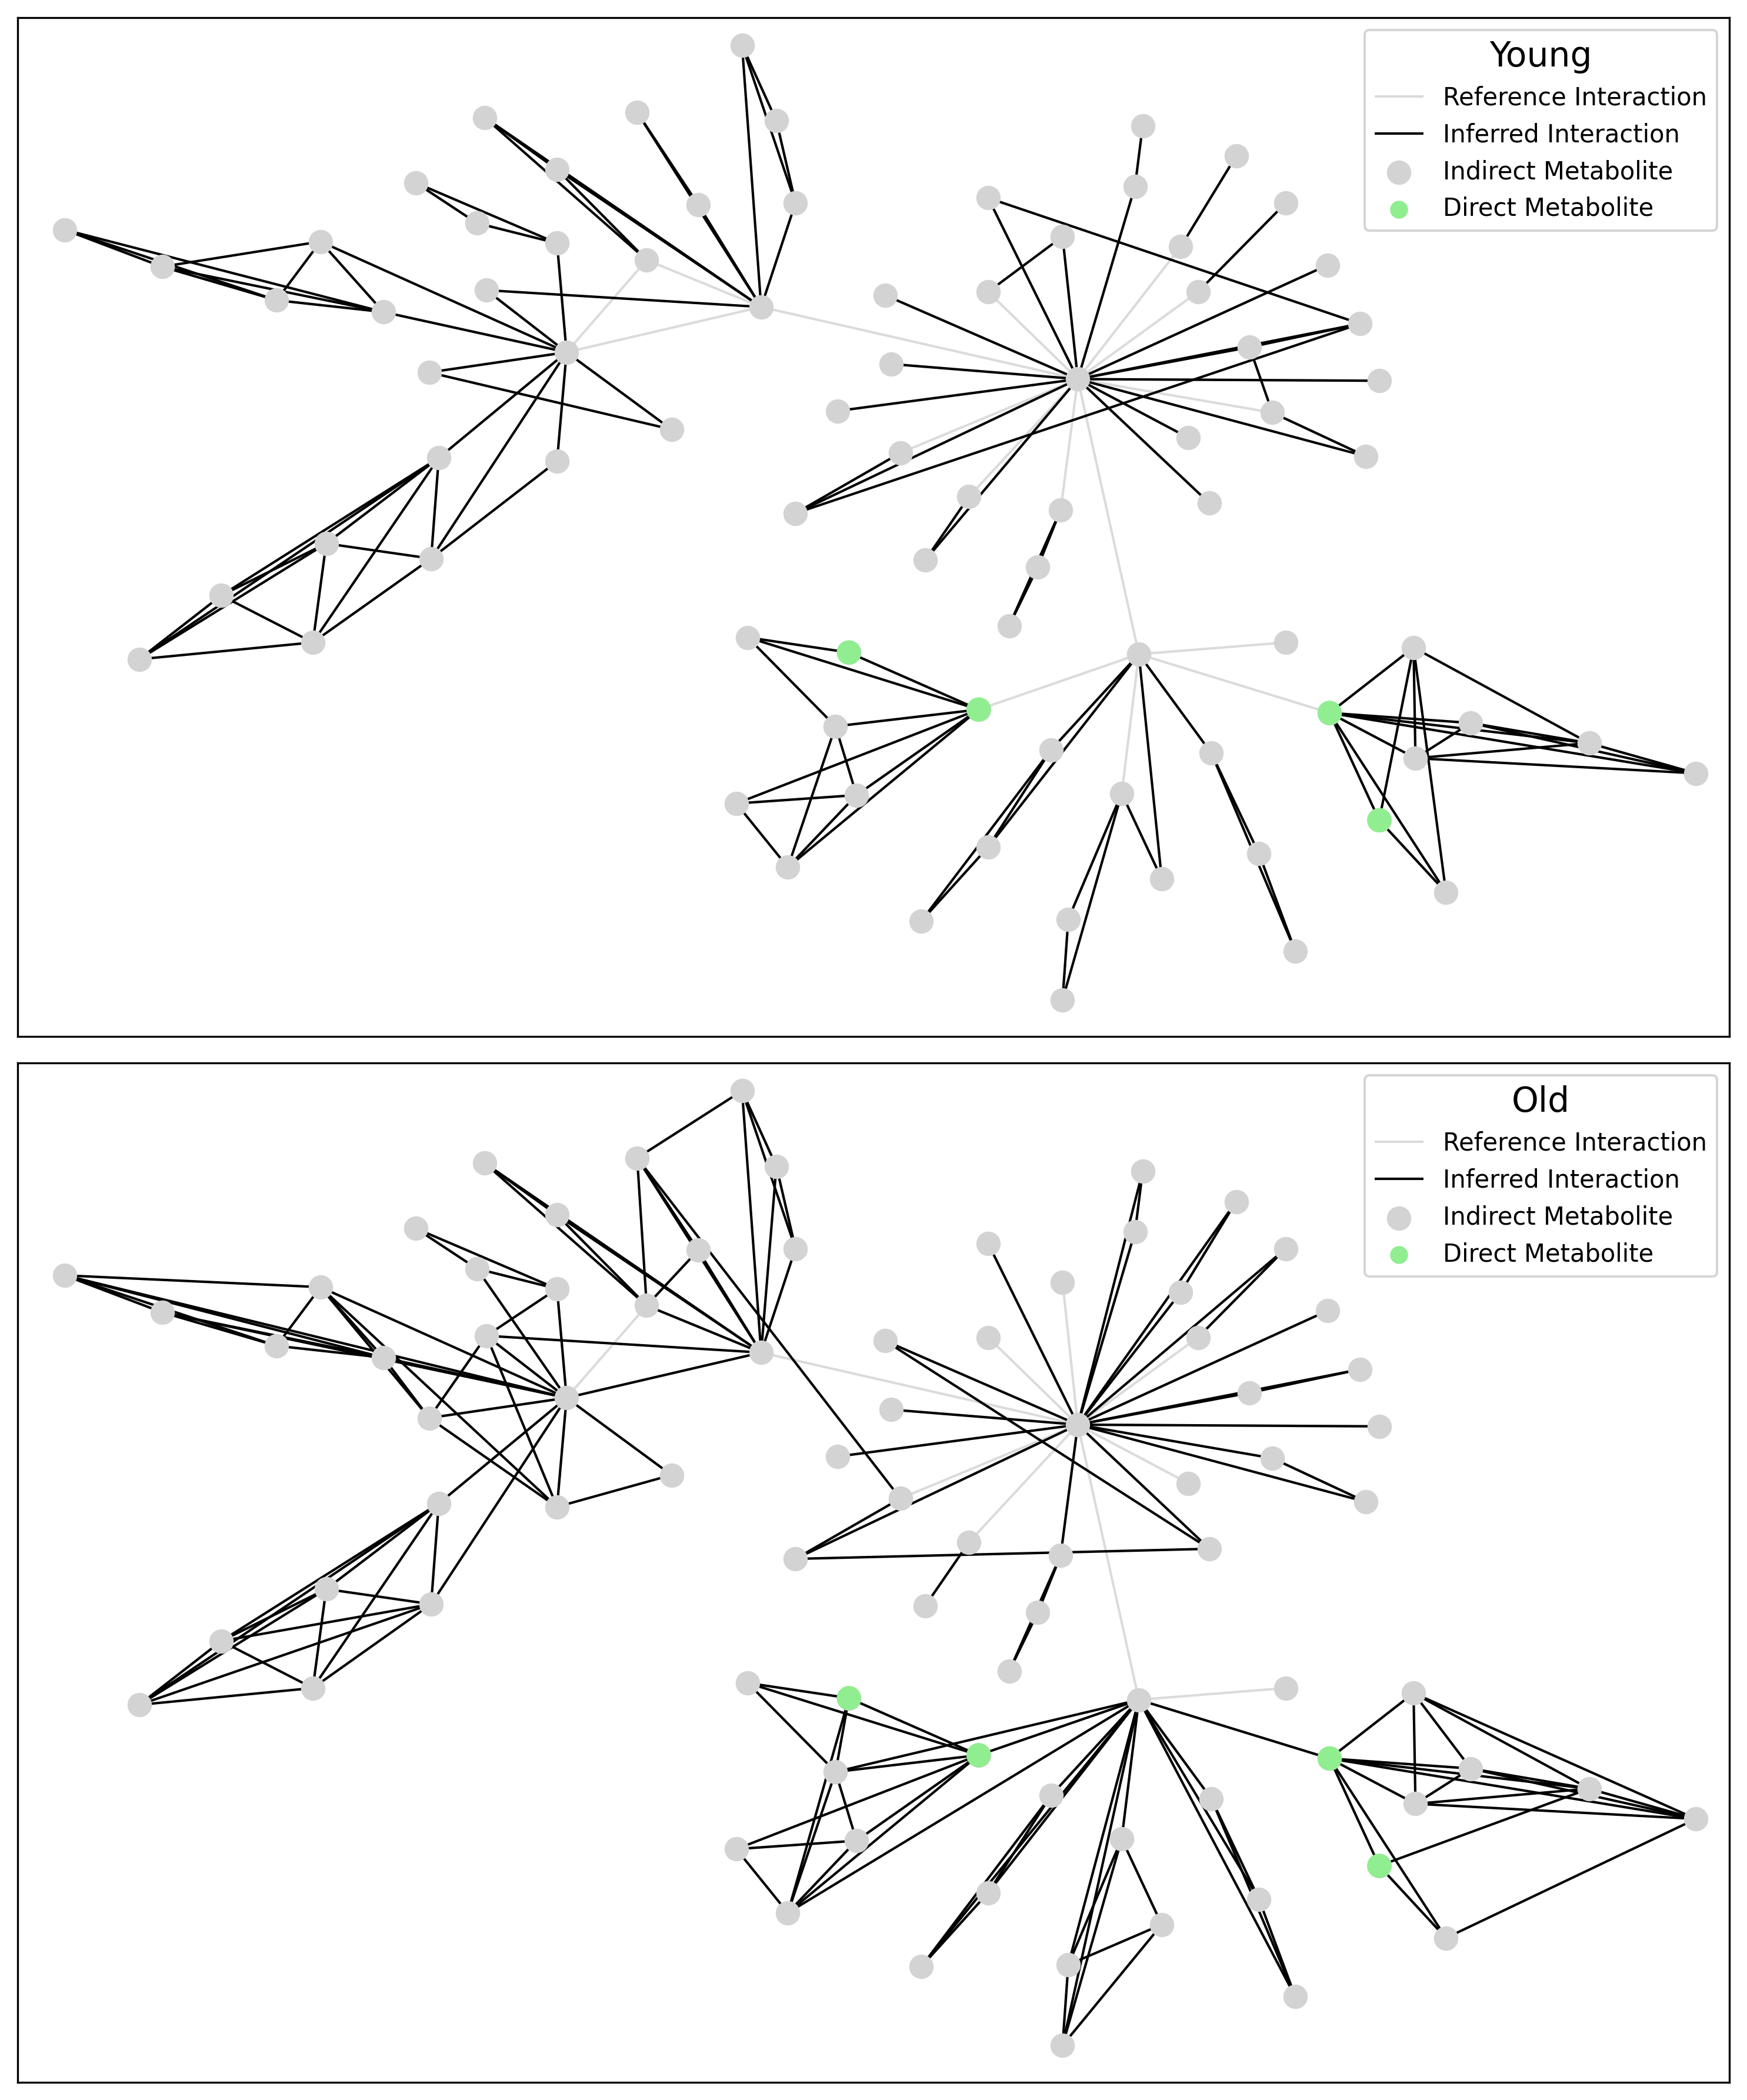

In [187]:

fig, ax = plt.subplots(2,1,figsize=(10,12),dpi=300)

# draw healthy graph
pos = process_positions()
edge_ref = nx.draw_networkx_edges(nx.from_numpy_array(experimental_config['ref_network']['adj']), pos=experimental_config['ref_network']['pos'],ax=ax[0], edge_color='lightgray',alpha=0.8)
nodes_ref = nx.draw_networkx_nodes(healthy_graph, pos=pos,
                                   ax=ax[0],node_color = 'lightgray',node_size=80)
node_active = nx.draw_networkx_nodes(healthy_graph, pos=pos,ax=ax[0],node_color = 'lightgreen',node_size=direct_metabolites)
edge_inf = nx.draw_networkx_edges(healthy_graph, pos=pos,ax=ax[0])
ax[0].legend([edge_ref,edge_inf,nodes_ref,node_active],
             ['Reference Interaction','Inferred Interaction','Indirect Metabolite','Direct Metabolite'],
             title='Young',title_fontproperties={'size':14})
ax[0].set_xlim(30,1950)
ax[0].set_ylim(-1300,0)

# draw disease graph
edge_ref = nx.draw_networkx_edges(nx.from_numpy_array(experimental_config['ref_network']['adj']), pos=experimental_config['ref_network']['pos'],ax=ax[1], edge_color='lightgray',alpha=0.8)
nodes_ref = nx.draw_networkx_nodes(disease_graph, pos=pos,ax=ax[1],node_color = 'lightgray',node_size=80)
node_active = nx.draw_networkx_nodes(disease_graph, pos=pos,ax=ax[1],node_color = 'lightgreen',node_size=direct_metabolites)
edge_inf = nx.draw_networkx_edges(disease_graph, pos=pos,ax=ax[1])
ax[1].legend([edge_ref,edge_inf,nodes_ref,node_active],
             ['Reference Interaction','Inferred Interaction','Indirect Metabolite','Direct Metabolite'],
             title='Old',title_fontproperties={'size':14})
ax[1].set_xlim(30,1950)
ax[1].set_ylim(-1300,0)

plt.tight_layout()

# plt.savefig(f'{VIS_PATH}/distribution_samples.png')
